# Aging Sim

In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate, integrate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)
import winsound
from pybamm import exp, constants, Parameter
import pickle
eSOH_DIR = "../data/esoh_R/"
oCV_DIR = "../data/ocv/"
cyc_DIR = "../data/cycling/"
fig_DIR = "../figures/figures_paper/"
res_DIR = "../data/results_paper/"
resistance_DIR = "../data/resistance/"
%matplotlib widget

In [2]:
parameter_values = get_parameter_values()

spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
        "lithium plating": "irreversible",
        "stress-induced diffusion": "false",
    }
)
# spm.print_parameter_info()
param=spm.param

In [3]:
cells = [1,4,7,10,13,16]
cell = 1
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
Ns = np.insert(N[1:]-1,0,0)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
print(cell_no)
pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")
experiment = pybamm.Experiment(
    [
        ("Discharge at "+c_rate_d+dis_set,
        "Rest for 10 sec",
        "Charge at "+c_rate_c+" until 4.2V", 
        "Hold at 4.2V until C/100")
    ] *dfe.N.iloc[-1],
    # ] *40,
    termination="50% capacity",
#     cccv_handling="ode",
)
Temp = 25
par_val = [4.0312e-08,1.8157e-07,1.0776,2.3586e-09,-4.9170e-09,-1.4406e-09]
parameter_values = get_parameter_values()
parameter_values.update(
    {
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        "Positive electrode LAM constant proportional term [s-1]": par_val[0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[1],
        "Positive electrode LAM constant proportional term 2 [s-1]": par_val[5],
        "Negative electrode LAM constant proportional term 2 [s-1]": par_val[4],
        "Positive electrode LAM constant exponential term": par_val[2],
        "Negative electrode LAM constant exponential term": par_val[2],
        "SEI kinetic rate constant [m.s-1]":  4.60788219e-16, #1.08494281e-16 , 
        "EC diffusivity [m2.s-1]": 4.56607447e-19,#8.30909086e-19,
        "SEI growth activation energy [J.mol-1]": 1.87422275e+04,#1.58777981e+04,
        "Lithium plating kinetic rate constant [m.s-1]": par_val[3],
        "Initial inner SEI thickness [m]": 0e-09,
        "Initial outer SEI thickness [m]": 5e-09,
        "SEI resistivity [Ohm.m]": 30000.0,
        "Negative electrode partial molar volume [m3.mol-1]": 7e-06,
        "Negative electrode LAM min stress [Pa]": 0,
        "Negative electrode LAM max stress [Pa]": 0,
        "Positive electrode LAM min stress [Pa]": 0,
        "Positive electrode LAM max stress [Pa]": 0,
    },
    check_already_exists=False,
)
if cell == 13 or cell == 16:
    parameter_values.update(
        {
            "Negative electrode partial molar volume [m3.mol-1]":	0.747*7e-06,
        },
        check_already_exists=False,
    )
all_sumvars_dict = cycle_adaptive_simulation_V2(spm, parameter_values, experiment,SOC_0, save_at_cycles=1)
# with open(res_DIR+'fast_sim_'+"cell_"+cell_no+'_sum_var.pickle', 'wb') as handle:
#     pickle.dump(all_sumvars_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


01
beta1= 1.8157e-07
beta2= -4.917e-09
min stress = 4947906.626973287
max stress = 4948199.140068515
j = -1.2671327275496018e-08
loss = -0.00044698729668452236
beta1= 1.8157e-07
beta2= -4.917e-09
min stress = 4966419.934613517
max stress = 4966711.509220541
j = -1.272242527853734e-08
loss = -0.0004472968721754908
beta1= 1.8157e-07
beta2= -4.917e-09
min stress = 4975747.961832581
max stress = 4976039.131973399
j = -1.2748176884518132e-08
loss = -0.0004474489201732943
beta1= 1.8157e-07
beta2= -4.917e-09
min stress = 4985097.972383391
max stress = 4985388.789204978
j = -1.2773992942789231e-08
loss = -0.00044758884691812673
beta1= 1.8157e-07
beta2= -4.917e-09
min stress = 5179893.461002408
max stress = 5180184.2809695415
j = -1.331268302205581e-08
loss = -0.00044976588814956076
beta1= 1.8157e-07
beta2= -4.917e-09
min stress = 5284649.218759545
max stress = 5284942.132654392
j = -1.3603030717849857e-08
loss = -0.0004516932046946881
beta1= 1.8157e-07
beta2= -4.917e-09
min stress = 5393027.77

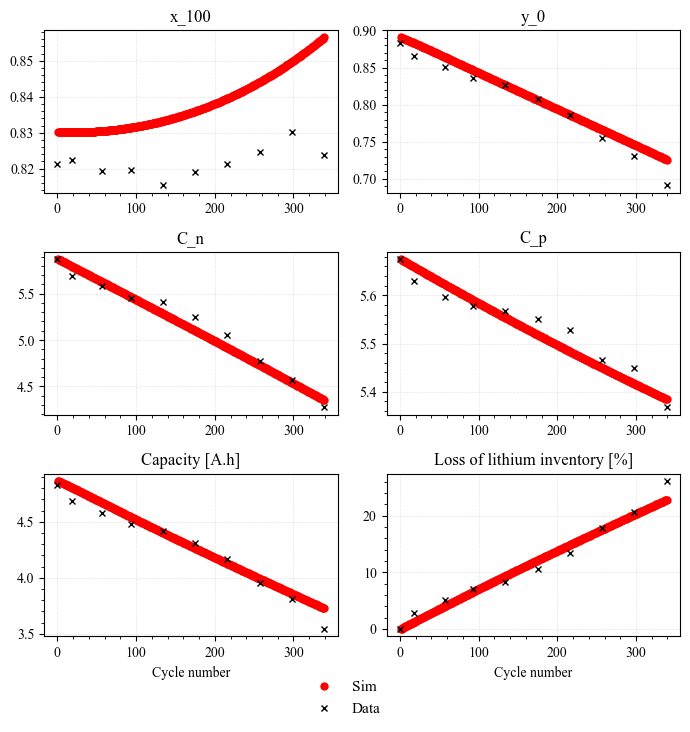

In [4]:
fig = plotc(all_sumvars_dict,dfe);
# plt.show()
# plt.savefig(fig_DIR +'plating_tuning'+'_'+cell_no+'_eSOH.png')

In [5]:
# sim_long = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
#                             solver=pybamm.CasadiSolver("safe"))
# sol_long = sim_long.solve(initial_soc=1)
# long_sol_output =sol_long.summary_variables

# Cycling Voltage Plots

In [6]:
# asdasdas

In [7]:
def load_cycling_data_ch(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no):
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    cycles = np.array(dfe_0['N'].astype('int'))+1
    cycles = cycles[1:]
    # print(cell_no)
    cyc_data_raw1 = pd.read_csv(cyc_DIR+'cycling_data_cell_'+cell_no+'.csv')
    if cell == 1:
        offset = 12
    else:
        offset = 0
    if len(cycles) == cyc_no+1:
        N1 = cyc_data_raw1["Cycle number"].iloc[-1]-offset
    else:
        N1 = cycles[cyc_no]
    print(N1)
    cyc_data_raw = cyc_data_raw1[ cyc_data_raw1['Cycle number'] == N1 ]
    cyc_data = cyc_data_raw.reset_index(drop=True)
    t_c1 = cyc_data['Time [s]']-cyc_data['Time [s]'][0]
    t_c1 = t_c1.values
    I_c1 = cyc_data['Current [mA]']/1000
    I_c1 = I_c1.values
    V_c1 = cyc_data['Voltage [V]']
    V_c1 = V_c1.values
    E_c1 = cyc_data["Expansion [mu m]"]
    E_c1 = E_c1.values
    idx_I = np.where(np.sign(I_c1[:-1]) != np.sign(I_c1[1:]))[0] 
    idx_I = idx_I[idx_I>50]
    t = t_c1[:idx_I[0]]
    V = V_c1[:idx_I[0]]
    I = I_c1[:idx_I[0]]
    E = E_c1[:idx_I[0]]-E_c1[0]
    # t = t_c1
    # V = V_c1
    # I = I_c1
    Q = integrate.cumtrapz(I,t, initial=0)/3600 #Ah
    
    return t,V,I,Q,E


In [8]:
def load_cycling_data_dh(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no):
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    cycles = np.array(dfe_0['N'].astype('int'))+1
    cycles = cycles[1:]
    # print(cell_no)
    cyc_data_raw1 = pd.read_csv(cyc_DIR+'cycling_data_cell_'+cell_no+'.csv')
    if cell == 1:
        offset = 12
    else:
        offset = 0
    if len(cycles) == cyc_no+1:
        N1 = cyc_data_raw1["Cycle number"].iloc[-1]-offset
    else:
        N1 = cycles[cyc_no]
    print(N1)
    cyc_data_raw = cyc_data_raw1[ cyc_data_raw1['Cycle number'] == N1 ]
    cyc_data = cyc_data_raw.reset_index(drop=True)
    t_c1 = cyc_data['Time [s]']-cyc_data['Time [s]'][0]
    t_c1 = t_c1.values
    I_c1 = cyc_data['Current [mA]']/1000
    I_c1 = I_c1.values
    V_c1 = cyc_data['Voltage [V]']
    V_c1 = V_c1.values
    E_c1 = cyc_data["Expansion [mu m]"]
    E_c1 = E_c1.values
    idx_I = np.where(np.sign(I_c1[:-1]) != np.sign(I_c1[1:]))[0] 
    idx_I = idx_I[idx_I>50]
    t = t_c1[idx_I[0]:]-t_c1[idx_I[0]]
    V = V_c1[idx_I[0]:]
    I = I_c1[idx_I[0]:]
    E = E_c1[idx_I[0]:]-E_c1[idx_I[0]]
    # t = t_c1
    # V = V_c1
    # I = I_c1
    Q = -1*integrate.cumtrapz(I,t, initial=0)/3600 #Ah
    
    return t,V,I,Q,E


In [9]:
def load_cycling_data(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no):
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    cycles = np.array(dfe_0['N'].astype('int'))+1
    cycles = cycles[1:]
    # print(cell_no)
    cyc_data_raw1 = pd.read_csv(cyc_DIR+'cycling_data_cell_'+cell_no+'.csv')
    if len(cycles) == cyc_no+1:
        N1 = cyc_data_raw1["Cycle number"].iloc[-2]-2
    else:
        N1 = cycles[cyc_no]
    print(N1)
    cyc_data_raw = cyc_data_raw1[ cyc_data_raw1['Cycle number'] == N1 ]
    cyc_data = cyc_data_raw.reset_index(drop=True)
    t_c1 = cyc_data['Time [s]']-cyc_data['Time [s]'][0]
    t_c1 = t_c1.values
    I_c1 = cyc_data['Current [mA]']/1000
    I_c1 = I_c1.values
    V_c1 = cyc_data['Voltage [V]']
    V_c1 = V_c1.values
    E_c1 = cyc_data["Expansion [mu m]"]
    E_c1 = E_c1.values
    idx_I = np.where(np.sign(I_c1[:-1]) != np.sign(I_c1[1:]))[0] 
    idx_I = idx_I[idx_I>50]
    t = t_c1
    V = V_c1
    I = I_c1
    E = E_c1-E_c1[0]
    # t = t_c1
    # V = V_c1
    # I = I_c1
    Q = integrate.cumtrapz(I,t, initial=0)/3600 #Ah
    
    return t,V,I,Q,E


In [10]:
def load_cycling_data_all(cell,eSOH_DIR,oCV_DIR,cyc_DIR):
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    cycles = np.array(dfe_0['N'].astype('int'))+1
    cycles = cycles[1:]
    # print(cell_no)
    cyc_data_raw1 = pd.read_csv(cyc_DIR+'cycling_data_cell_'+cell_no+'.csv')
    # if len(cycles) == cyc_no+1:
    #     N1 = cyc_data_raw1["Cycle number"].iloc[-2]-2
    # else:
    #     N1 = cycles[cyc_no]
    # print(N1)
    # cyc_data_raw = cyc_data_raw1[ cyc_data_raw1['Cycle number'] == N1 ]
    cyc_data = cyc_data_raw1.reset_index(drop=True)
    t_c1 = cyc_data['Time [s]']-cyc_data['Time [s]'][0]
    t_c1 = t_c1.values
    I_c1 = cyc_data['Current [mA]']/1000
    I_c1 = I_c1.values
    V_c1 = cyc_data['Voltage [V]']
    V_c1 = V_c1.values
    E_c1 = cyc_data["Expansion [mu m]"]
    E_c1 = E_c1.values
    # idx_I = np.where(np.sign(I_c1[:-1]) != np.sign(I_c1[1:]))[0] 
    # idx_I = idx_I[idx_I>50]
    t = t_c1
    V = V_c1
    I = I_c1
    E = E_c1#-E_c1[0]
    # t = t_c1
    # V = V_c1
    # I = I_c1
    Q = integrate.cumtrapz(I,t, initial=0)/3600 #Ah
    
    return t,V,I,Q,E


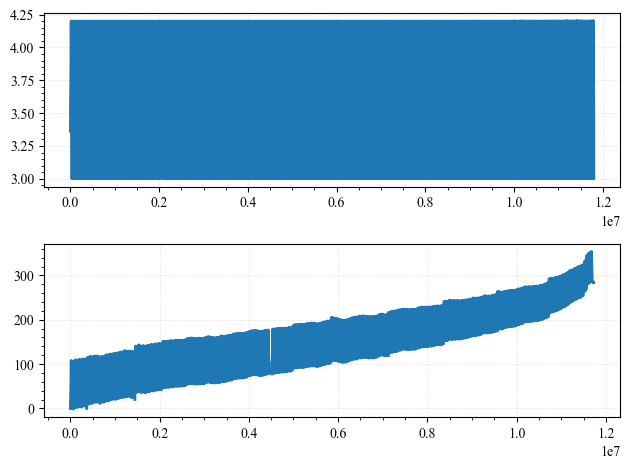

In [11]:
t_all,V_all,I_all,Q_all,E_all = load_cycling_data_all(cell,eSOH_DIR,oCV_DIR,cyc_DIR)
fig ,ax = plt.subplots(2,1)
ax1 = ax.flat[0]
ax1.plot(t_all,V_all)
ax2 = ax.flat[1]
ax2.plot(t_all,E_all-E_all[1])
fig.tight_layout()
# plt.savefig(fig_DIR +'volt_exp_'+cell_no+'_all_t.png')

In [12]:
dis_set = " until 3V"

if c_rate_d=="C/5":
    timestep = '10 sec'
else:
    timestep = '1 sec'

experiment_cyc_comp_ch = pybamm.Experiment(
    [
        "Discharge at "+c_rate_d+dis_set,
        "Rest for 10 sec",
        "Charge at "+c_rate_c+" until 4.2V", 
        "Hold at 4.2V until C/100",
        "Rest for 10 sec",
        "Discharge at "+c_rate_d+dis_set,
    ],
    period=timestep,
)
Ns = np.insert(N[1:]-1,0,0)

In [13]:
def cyc_comp_ch(cyc_no,eSOH,t_d,Q_d,V_d,E_d,parameter_values):
    # dfo = dfo_0[dfo_0['N']==N[cyc_no]]
    model = spm
    Vmin = 3.0
    Vmax = 4.2
    esoh_model = pybamm.lithium_ion.ElectrodeSOH()
    esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
    param = model.param
    Cn = eSOH["C_n"][Ns[cyc_no]]
    # print(Cn)
    Cp = eSOH["C_p"][Ns[cyc_no]]
    c_n_max = parameter_values.evaluate(param.n.prim.c_max)
    c_p_max = parameter_values.evaluate(param.p.prim.c_max)
    n_Li_init = eSOH["Total lithium in particles [mol]"][Ns[cyc_no]]
    eps_n_data = parameter_values.evaluate(Cn*3600/(param.n.L * param.n.prim.c_max * param.F* param.A_cc))
    eps_p_data = parameter_values.evaluate(Cp*3600/(param.p.L * param.p.prim.c_max * param.F* param.A_cc))
    del_sei = eSOH['X-averaged SEI thickness [m]'][Ns[cyc_no]]
    c_plated_Li = eSOH['X-averaged lithium plating concentration [mol.m-3]'][Ns[cyc_no]]
    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
        solver=pybamm.AlgebraicSolver(),
    )

    parameter_values.update(
        {
            "Initial concentration in negative electrode [mol.m-3]": esoh_sol[
       "x_100"
            ].data[0]
            * c_n_max,
            "Initial concentration in positive electrode [mol.m-3]": esoh_sol[
                "y_100"
            ].data[0]
            * c_p_max,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            "Initial temperature [K]": 273.15+25,
            "Ambient temperature [K]": 273.15+25,
            "Initial inner SEI thickness [m]": 0e-09,
            # "Initial outer SEI thickness [m]": 5e-09,
            "Initial outer SEI thickness [m]": del_sei,
            "Initial plated lithium concentration [mol.m-3]": c_plated_Li,        
        }
    )

    sim_exp = pybamm.Simulation(
        model, experiment=experiment_cyc_comp_ch, parameter_values=parameter_values,
        solver=pybamm.CasadiSolver(mode="safe", rtol=1e-6, atol=1e-6,dt_max=0.1),
    )
    sol_exp = sim_exp.solve()
    t_t = sol_exp["Time [s]"].entries
    I_t = sol_exp["Current [A]"].entries
    Q_t = -sol_exp['Discharge capacity [A.h]'].entries
    Vt_t = sol_exp["Terminal voltage [V]"].entries
    exp_t = 30e6*sol_exp["Cell thickness change [m]"].entries
    idx = np.where(np.diff(np.sign(-I_t)))[0]
    I = I_t[idx[0]:]
    t = t_t[idx[0]:]-t_t[idx[0]]
    Q = Q_t[idx[0]:]-Q_t[idx[0]]
    Vt = Vt_t[idx[0]:]
    Exp = exp_t[idx[0]:]-exp_t[idx[0]]

    if max(t)<max(t_d):
        int_V = interpolate.CubicSpline(t_d,V_d,extrapolate=True)
        rmse_V = pybamm.rmse(Vt,int_V(t))
        int_E = interpolate.CubicSpline(t_d,E_d,extrapolate=True)
        rmse_E = pybamm.rmse(Exp,int_E(t))
        # int_VQ = interpolate.CubicSpline(Q_d,V_d,extrapolate=True)
        # rmse_VQ = pybamm.rmse(Vt,int_VQ(Q))
        # int_EQ = interpolate.CubicSpline(Q_d,E_d,extrapolate=True)
        # rmse_EQ = pybamm.rmse(Exp,int_EQ(Q))
    else:
        int_V = interpolate.CubicSpline(t,Vt,extrapolate=True)
        rmse_V = pybamm.rmse(V_d,int_V(t_d))
        int_E = interpolate.CubicSpline(t,Exp,extrapolate=True)
        rmse_E = pybamm.rmse(E_d,int_E(t_d))
        # int_VQ = interpolate.CubicSpline(Q[1:],Vt[1:],extrapolate=True)
        # rmse_VQ = pybamm.rmse(V_d,int_VQ(Q_d))
        # int_EQ = interpolate.CubicSpline(Q[1:],Exp[1:],extrapolate=True)
        # rmse_EQ = pybamm.rmse(E_d,int_EQ(Q_d))
    # rmse_V =0
    # max_V = 0
    rmse_VQ  = 0 ; rmse_EQ = 0
    return t,I,Q,Vt,Exp,sol_exp,rmse_V,rmse_E,rmse_VQ,rmse_EQ

In [14]:
experiment_cyc_comp_dh = pybamm.Experiment(
    [
        "Rest for 10 sec",
        "Discharge at "+c_rate_d+dis_set,
        "Rest for 10 sec",
        "Charge at "+c_rate_c+" until 4.2V", 
        "Hold at 4.2V until C/100",
        # "Rest for 10 sec",
        # "Discharge at "+c_rate_d+dis_set,
    ],
    period=timestep,
)

In [15]:
def cyc_comp_dh(cyc_no,eSOH,t_d,Q_d,V_d,E_d,parameter_values):
    model = spm
    Vmin = 3.0
    Vmax = 4.2
    esoh_model = pybamm.lithium_ion.ElectrodeSOH()
    esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
    param = model.param
    Cn = eSOH["C_n"][Ns[cyc_no]]
    Cp = eSOH["C_p"][Ns[cyc_no]]
    c_n_max = parameter_values.evaluate(param.n.prim.c_max)
    c_p_max = parameter_values.evaluate(param.p.prim.c_max)
    n_Li_init = eSOH["Total lithium in particles [mol]"][Ns[cyc_no]]
    eps_n_data = parameter_values.evaluate(Cn*3600/(param.n.L * param.n.prim.c_max * param.F* param.A_cc))
    eps_p_data = parameter_values.evaluate(Cp*3600/(param.p.L * param.p.prim.c_max * param.F* param.A_cc))
    del_sei = eSOH['X-averaged SEI thickness [m]'][Ns[cyc_no]]
    c_plated_Li = eSOH['X-averaged lithium plating concentration [mol.m-3]'][Ns[cyc_no]]
    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
        solver=pybamm.AlgebraicSolver(),
    )

    parameter_values.update(
        {
            "Initial concentration in negative electrode [mol.m-3]": esoh_sol[
       "x_100"
            ].data[0]
            * c_n_max,
            "Initial concentration in positive electrode [mol.m-3]": esoh_sol[
                "y_100"
            ].data[0]
            * c_p_max,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            "Initial temperature [K]": 273.15+25,
            "Ambient temperature [K]": 273.15+25,
            "Initial inner SEI thickness [m]": 0e-09,
            "Initial outer SEI thickness [m]": del_sei,
            "Initial plated lithium concentration [mol.m-3]": c_plated_Li,
        }
    )

    sim_exp = pybamm.Simulation(
        model, experiment=experiment_cyc_comp_dh, parameter_values=parameter_values,
        solver=pybamm.CasadiSolver(mode="safe", rtol=1e-6, atol=1e-6,dt_max=0.1),
    )
    sol_exp = sim_exp.solve()
    t_t = sol_exp["Time [s]"].entries
    I_t = sol_exp["Current [A]"].entries
    Q_t = sol_exp['Discharge capacity [A.h]'].entries
    Vt_t = sol_exp["Terminal voltage [V]"].entries
    exp_t = 30e6*sol_exp["Cell thickness change [m]"].entries
    idx = np.where(np.diff(np.sign(-I_t)))[0]
    I = I_t[idx[0]:idx[1]+1]
    t = t_t[idx[0]:idx[1]+1]-t_t[idx[0]]
    Q = Q_t[idx[0]:idx[1]+1]
    Vt = Vt_t[idx[0]:idx[1]+1]
    Exp = exp_t[idx[0]:idx[1]+1]-exp_t[idx[0]]
    if max(t)<max(t_d):
        int_V = interpolate.CubicSpline(t_d,V_d,extrapolate=True)
        rmse_V = pybamm.rmse(Vt,int_V(t))
        int_E = interpolate.CubicSpline(t_d,E_d,extrapolate=True)
        rmse_E = pybamm.rmse(Exp,int_E(t))
        # int_VQ = interpolate.CubicSpline(Q_d,V_d,extrapolate=True)
        # rmse_VQ = pybamm.rmse(Vt,int_VQ(Q))
        # int_EQ = interpolate.CubicSpline(Q_d,E_d,extrapolate=True)
        # rmse_EQ = pybamm.rmse(Exp,int_EQ(Q))
    else:
        int_V = interpolate.CubicSpline(t,Vt,extrapolate=True)
        rmse_V = pybamm.rmse(V_d,int_V(t_d))
        int_E = interpolate.CubicSpline(t,Exp,extrapolate=True)
        rmse_E = pybamm.rmse(E_d,int_E(t_d))
        # int_VQ = interpolate.CubicSpline(Q,Vt,extrapolate=True)
        # rmse_VQ = pybamm.rmse(V_d,int_VQ(Q_d))
        # int_EQ = interpolate.CubicSpline(Q,Exp,extrapolate=True)
        # rmse_EQ = pybamm.rmse(E_d,int_EQ(Q_d))
    # rmse_V =0
    # max_V = 0
    rmse_VQ  = 0 ; rmse_EQ = 0
    return t,I,Q,Vt,Exp,sol_exp,rmse_V,rmse_E,rmse_VQ,rmse_EQ

In [16]:
# sdfdsfs

0
42
5
217
8
340


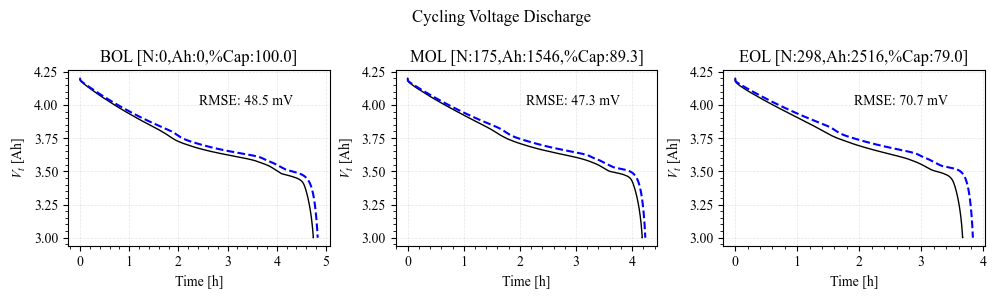

In [19]:
cyc_no=0
# cyc_no=len(N)-1
i=0
titles = ["BOL","MOL","EOL"]
fig, ax = plt.subplots(1,3,figsize=(10,3))
for cyc_no in [0,int((len(N)+1)/2),len(N)-2]:
    # cyc_no=0
    print(cyc_no)
    t_d,V_d,I_d,Q_d,E_d = load_cycling_data_dh(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
    # parameter_values.update(
    # {
    #     "Positive electrode LAM constant proportional term [s-1]": par_val[2][0],
    #     "Negative electrode LAM constant proportional term [s-1]": par_val[2][1],
    #     "Positive electrode LAM constant exponential term": par_val[2][2],
    #     "Negative electrode LAM constant exponential term": par_val[2][2],
    #     "Lithium plating kinetic rate constant [m.s-1]": par_val[2][3],
    #     "SEI resistivity [Ohm.m]": 30000.0,
    # },
    # check_already_exists=False,
    # )
    t,I,Q,Vt,Exp,sol,rmse_V,rmse_E,rmse_VQ,rmse_EQ = cyc_comp_dh(cyc_no,all_sumvars_dict,t_d,Q_d,V_d,E_d,parameter_values)
    # if cyc_no in [0,int((len(N)+1)/2),len(N)-3]:
    ax1 = ax.flat[i]
    ax1.plot(t_d/3600,V_d,'k',linewidth=1)
    ax1.plot(t/3600,Vt,'b--',linewidth=1.5)
    ax1.set_xlabel('Time [h]')
    # ax1.set_xlabel('Q [Ah]')
    ax1.text(0.5,0.8,f'RMSE: {rmse_V*1e3:0.1f} mV',transform=ax1.transAxes)
    ax1.set_ylabel('$V_t$ [Ah]')
    ax1.set_title('{} [N:{:0.0f},Ah:{:0.0f},%Cap:{:0.1f}]'.format(titles[i],N[cyc_no],dfe['Ah_th'][cyc_no],(dfe["Cap"][cyc_no]/dfe["Cap"][0])*100))
    i+=1
fig.suptitle('Cycling Voltage Discharge')
fig.tight_layout()
# plt.savefig(fig_DIR +'volt_error_cell_'+cell_no+'_dh_t.png')

## Cycling Voltage: Charge

0
42
5
217
8
340


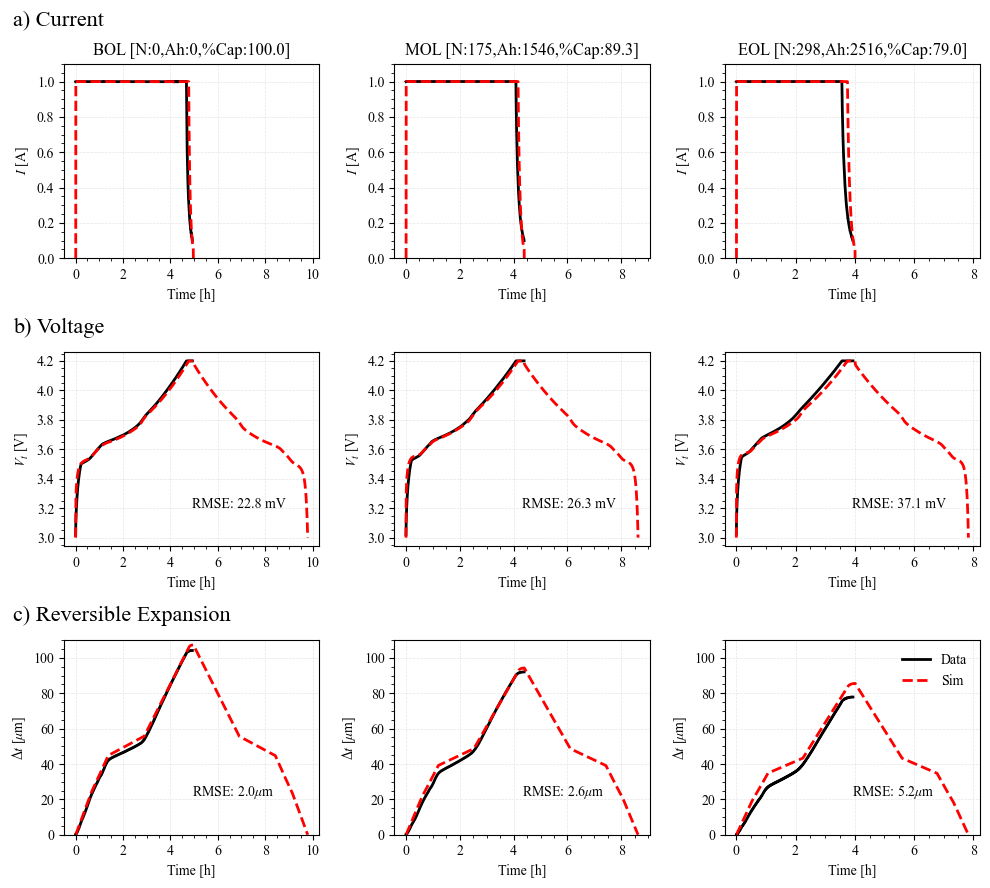

In [20]:
cyc_no=0
# cyc_no=len(N)-1
titles = ["BOL","MOL","EOL"]
i = 0
fig, ax = plt.subplots(3,3,figsize=(10,9))
for cyc_no in [0,int((len(N)+1)/2),len(N)-2]:
    print(cyc_no)
    t_d,V_d,I_d,Q_d,E_d = load_cycling_data_ch(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
    # parameter_values.update(
    # {
    #     "Positive electrode LAM constant proportional term [s-1]": par_val[2][0],
    #     "Negative electrode LAM constant proportional term [s-1]": par_val[2][1],
    #     "Positive electrode LAM constant exponential term": par_val[2][2],
    #     "Negative electrode LAM constant exponential term": par_val[2][2],
    #     "Lithium plating kinetic rate constant [m.s-1]": par_val[2][3],
    #     "SEI resistivity [Ohm.m]": 30000.0,
    # },
    # check_already_exists=False,
    # )
    t,I,Q,Vt,Exp,sol,rmse_V,rmse_E,rmse_VQ,rmse_EQ = cyc_comp_ch(cyc_no,all_sumvars_dict,t_d,Q_d,V_d,E_d,parameter_values)
    ax1 = ax.flat[i+3]
    ax1.plot(t_d/3600,V_d,'k',linewidth=2)
    ax1.plot(t/3600,Vt,'r--',linewidth=2)
    ax1.set_xlabel('Time [h]')
    ax1.text(0.5,0.2,f'RMSE: {rmse_V*1e3:0.1f} mV',transform=ax1.transAxes)
    ax1.set_ylabel('$V_t$ [V]')
    ax2 = ax.flat[i]
    ax2.plot(t_d/3600,I_d,'k',linewidth=2)
    ax2.plot(t/3600,-I,'r--',linewidth=2)
    ax2.set_xlabel('Time [h]')
    ax2.set_ylim(bottom=0)
    ax2.set_ylabel('$I$ [A]')
    ax2.set_title('{} [N:{:0.0f},Ah:{:0.0f},%Cap:{:0.1f}]'.format(titles[i],N[cyc_no],dfe['Ah_th'][cyc_no],(dfe["Cap"][cyc_no]/dfe["Cap"][0])*100))
    ax3 = ax.flat[i+6]
    ax3.plot(t_d/3600,E_d,'k',linewidth=2)
    ax3.plot(t/3600,Exp,'r--',linewidth=2)
    ax3.set_xlabel('Time [h]')
    ax3.set_ylim([0,110])
    ax3.set_ylabel('$\Delta t$ [$\mu$m]')
    ax3.text(0.5,0.2,f'RMSE: {rmse_E:0.1f}'+ r'$\mu$m',transform=ax3.transAxes)
    i+=1
ax3.legend(["Data","Sim"])
ax10 = ax.flat[0]
ax10.text(-0.2,1.2,f'a) Current',transform=ax10.transAxes,fontsize=16)
ax20 = ax.flat[3]
ax20.text(-0.2,1.1,f'b) Voltage',transform=ax20.transAxes,fontsize=16)
ax30 = ax.flat[6]
ax30.text(-0.2,1.1,f'c) Reversible Expansion',transform=ax30.transAxes,fontsize=16)
# fig.suptitle('Cycling Voltage Charge')
fig.tight_layout()
# plt.savefig(fig_DIR +'volt_exp_error_cell_'+cell_no+'_ch_t.png')
# plt.savefig(fig_DIR +'volt_error_cell_'+cell_no+'_ch_Q.png')

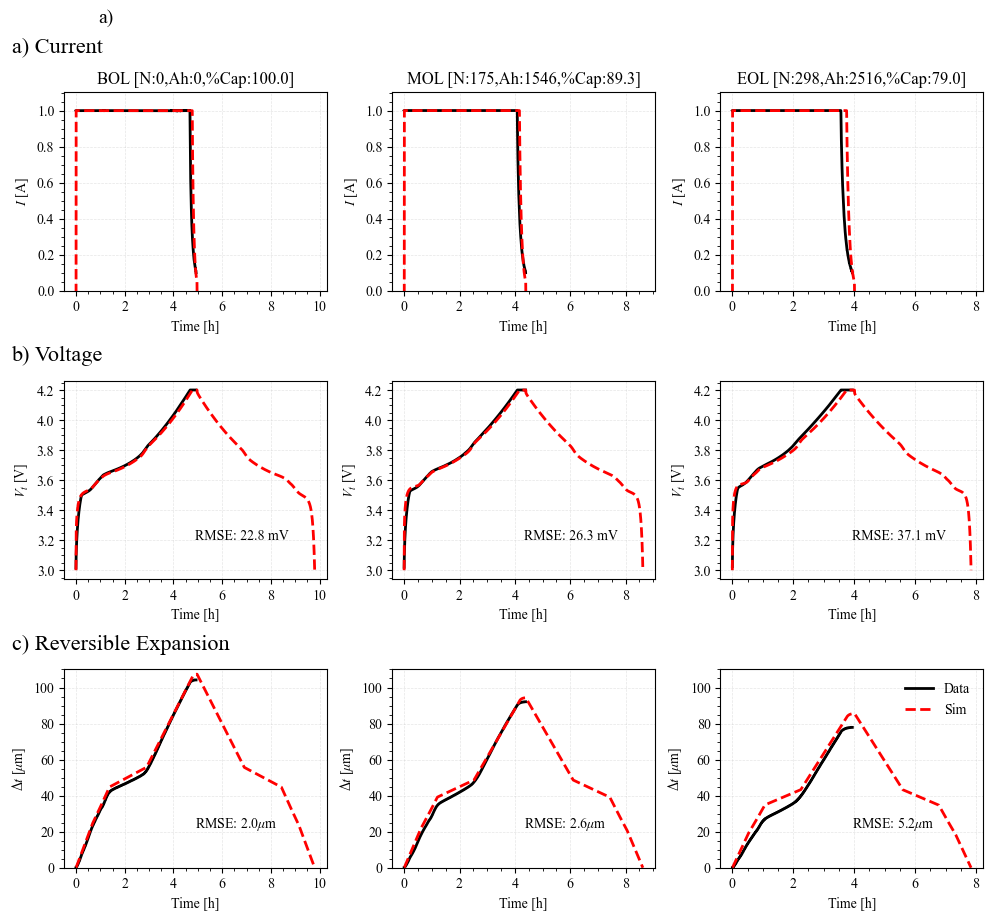

In [21]:
fig.text(0.1,1,f'a)',fontsize=14)
fig.tight_layout()
plt.show()

In [22]:
# sdsdfsd

NameError: name 'sdsdfsd' is not defined

0
42
5
217
8
340


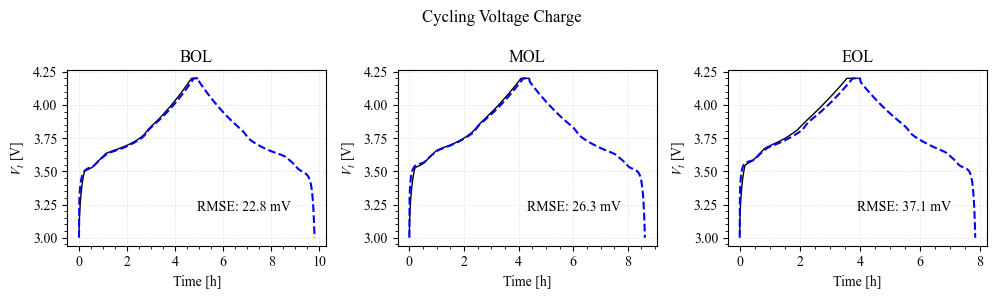

In [23]:
cyc_no=0
# cyc_no=len(N)-1
titles = ["BOL","MOL","EOL"]
i = 0
fig, ax = plt.subplots(1,3,figsize=(10,3))
for cyc_no in [0,int((len(N)+1)/2),len(N)-2]:
    print(cyc_no)
    t_d,V_d,I_d,Q_d,E_d = load_cycling_data_ch(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
    # parameter_values.update(
    # {
    #     "Positive electrode LAM constant proportional term [s-1]": par_val[2][0],
    #     "Negative electrode LAM constant proportional term [s-1]": par_val[2][1],
    #     "Positive electrode LAM constant exponential term": par_val[2][2],
    #     "Negative electrode LAM constant exponential term": par_val[2][2],
    #     "Lithium plating kinetic rate constant [m.s-1]": par_val[2][3],
    #     "SEI resistivity [Ohm.m]": 30000.0,
    # },
    # check_already_exists=False,
    # )
    t,I,Q,Vt,Exp,sol,rmse_V,rmse_E,rmse_VQ,rmse_EQ = cyc_comp_ch(cyc_no,all_sumvars_dict,t_d,Q_d,V_d,E_d,parameter_values)
    ax1 = ax.flat[i]
    # ax1.plot(t_d/3600,V_d,'k',linewidth=1)
    # ax1.plot(t/3600,Vt,'b--',linewidth=1.5)
    ax1.plot(t_d/3600,V_d,'k',linewidth=1)
    ax1.plot(t/3600,Vt,'b--',linewidth=1.5)
    # ax1.set_xlabel('Time [h]')
    ax1.set_xlabel('Time [h]')
    ax1.text(0.5,0.2,f'RMSE: {rmse_V*1e3:0.1f} mV',transform=ax1.transAxes)
    ax1.set_ylabel('$V_t$ [V]')
    ax1.set_title('{}'.format(titles[i]))
    i+=1
fig.suptitle('Cycling Voltage Charge')
fig.tight_layout()
# plt.savefig(fig_DIR +'volt_error_cell_'+cell_no+'_ch_t.png')
# plt.savefig(fig_DIR +'volt_error_cell_'+cell_no+'_ch_Q.png')

0
42
5
217
9
367


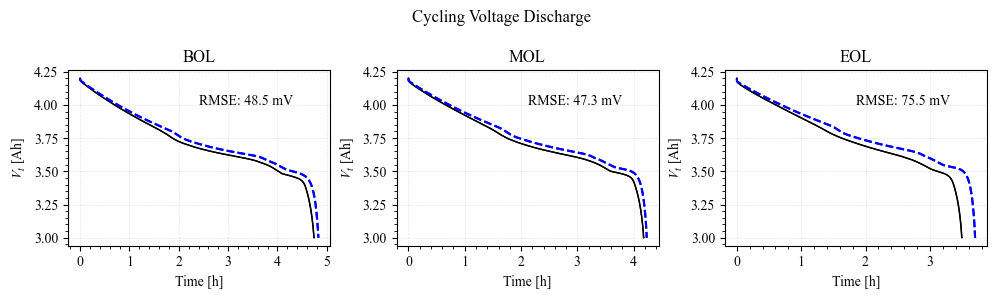

In [24]:
cyc_no=0
# cyc_no=len(N)-1
i=0
titles = ["BOL","MOL","EOL"]
fig, ax = plt.subplots(1,3,figsize=(10,3))
for cyc_no in [0,int((len(N)+1)/2),len(N)-1]:
    # cyc_no=0
    print(cyc_no)
    t_d,V_d,I_d,Q_d,E_d = load_cycling_data_dh(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
    # parameter_values.update(
    # {
    #     "Positive electrode LAM constant proportional term [s-1]": par_val[2][0],
    #     "Negative electrode LAM constant proportional term [s-1]": par_val[2][1],
    #     "Positive electrode LAM constant exponential term": par_val[2][2],
    #     "Negative electrode LAM constant exponential term": par_val[2][2],
    #     "Lithium plating kinetic rate constant [m.s-1]": par_val[2][3],
    #     "SEI resistivity [Ohm.m]": 30000.0,
    # },
    # check_already_exists=False,
    # )
    t,I,Q,Vt,Exp,sol,rmse_V,rmse_E,rmse_VQ,rmse_EQ = cyc_comp_dh(cyc_no,all_sumvars_dict,t_d,Q_d,V_d,E_d,parameter_values)
    # if cyc_no in [0,int((len(N)+1)/2),len(N)-3]:
    ax1 = ax.flat[i]
    ax1.plot(t_d/3600,V_d,'k',linewidth=1)
    ax1.plot(t/3600,Vt,'b--',linewidth=1.5)
    ax1.plot(Q_d,V_d,'k',linewidth=1)
    ax1.plot(Q,Vt,'b--',linewidth=1.5)
    ax1.set_xlabel('Time [h]')
    # ax1.set_xlabel('Q [Ah]')
    ax1.text(0.5,0.8,f'RMSE: {rmse_V*1e3:0.1f} mV',transform=ax1.transAxes)
    ax1.set_ylabel('$V_t$ [Ah]')
    ax1.set_title('{}'.format(titles[i]))
    i+=1
fig.suptitle('Cycling Voltage Discharge')
fig.tight_layout()
# plt.savefig(fig_DIR +'volt_error_cell_'+cell_no+'_dh_t.png')
# plt.savefig(fig_DIR +'volt_error_cell_'+cell_no+'_dh_Q.png')

In [25]:
Q

array([0.00000000e+00, 2.77777778e-03, 5.55555556e-03, ...,
       3.69722222e+00, 3.70000000e+00, 3.70000026e+00])

8
340


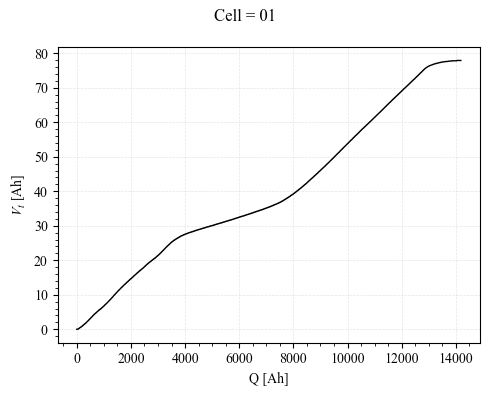

In [26]:
rmse_V_lc = []
fig, axes = plt.subplots(1,1,figsize=(5,4))
cyc_no=len(N)-2
print(cyc_no)
t_d,V_d,I_d,Q_d,E_d = load_cycling_data_ch(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
ax2 = axes
ax2.plot(t_d,E_d,'k',linewidth=1)
ax2.set_xlabel('Q [Ah]')
ax2.set_ylabel('$V_t$ [Ah]')
fig.suptitle('Cell = '+cell_no)
fig.tight_layout()
# plt.savefig(fig_DIR +'volt_error_'+cell_no+'_cyc_comp_resistivity.png')

# Expansion Plots

0
42
5
217
9
367


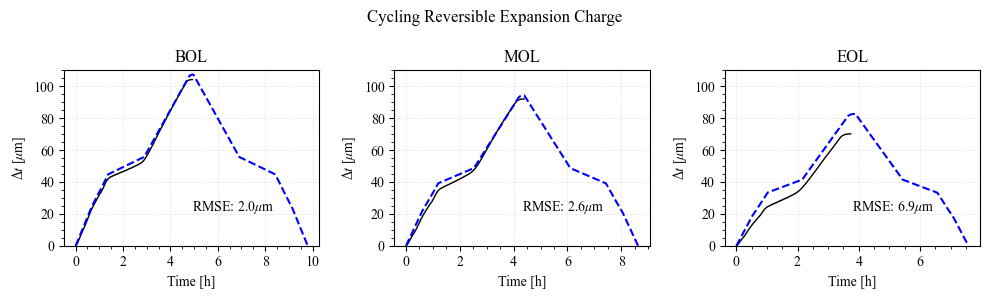

In [27]:
cyc_no=0
# cyc_no=len(N)-1
titles = ["BOL","MOL","EOL"]
i = 0
fig, ax = plt.subplots(1,3,figsize=(10,3))
for cyc_no in [0,int((len(N)+1)/2),len(N)-1]:
    print(cyc_no)
    t_d,V_d,I_d,Q_d,E_d = load_cycling_data_ch(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
    # parameter_values.update(
    # {
    #     "Positive electrode LAM constant proportional term [s-1]": par_val[2][0],
    #     "Negative electrode LAM constant proportional term [s-1]": par_val[2][1],
    #     "Positive electrode LAM constant exponential term": par_val[2][2],
    #     "Negative electrode LAM constant exponential term": par_val[2][2],
    #     "Lithium plating kinetic rate constant [m.s-1]": par_val[2][3],
    #     "SEI resistivity [Ohm.m]": 30000.0,
    # },
    # check_already_exists=False,
    # )
    t,I,Q,Vt,Exp,sol,rmse_V,rmse_E,rmse_VQ,rmse_EQ = cyc_comp_ch(cyc_no,all_sumvars_dict,t_d,Q_d,V_d,E_d,parameter_values)
    ax1 = ax.flat[i]
    ax1.plot(t_d/3600,E_d,'k',linewidth=1)
    ax1.plot(t/3600,Exp,'b--',linewidth=1.5)
    ax1.set_xlabel('Time [h]')
    ax1.text(0.5,0.2,f'RMSE: {rmse_E:0.1f}'+ r'$\mu$m',transform=ax1.transAxes)
    ax1.set_ylim([0,110])
    ax1.set_ylabel('$\Delta t$ [$\mu$m]')
    ax1.set_title('{}'.format(titles[i]))
    i+=1
fig.suptitle('Cycling Reversible Expansion Charge')
fig.tight_layout()
# plt.savefig(fig_DIR +'exp_error_cell_'+cell_no+'_ch.png')

0
42


NameError: name 'eSOH' is not defined

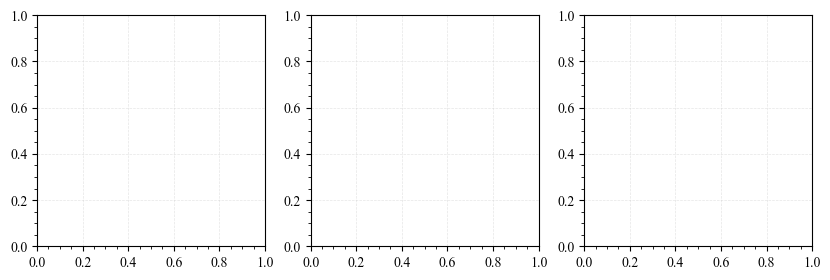

In [30]:
cyc_no=0
# cyc_no=len(N)-1
i=0
titles = ["BOL","MOL","EOL"]
fig, ax = plt.subplots(1,3,figsize=(10,3))
for cyc_no in [0,int((len(N)+1)/2),len(N)-1]:
    # cyc_no=0
    print(cyc_no)
    t_d,V_d,I_d,Q_d,E_d = load_cycling_data_dh(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
    # parameter_values.update(
    # {
    #     "Positive electrode LAM constant proportional term [s-1]": par_val[2][0],
    #     "Negative electrode LAM constant proportional term [s-1]": par_val[2][1],
    #     "Positive electrode LAM constant exponential term": par_val[2][2],
    #     "Negative electrode LAM constant exponential term": par_val[2][2],
    #     "Lithium plating kinetic rate constant [m.s-1]": par_val[2][3],
    #     "SEI resistivity [Ohm.m]": 30000.0,
    # },
    # check_already_exists=False,
    # )
    t,I,Q,Vt,Exp,sol,rmse_V,rmse_E = cyc_comp_dh(cyc_no,eSOH,all_sumvars_dict,t_d,V_d,E_d,parameter_values)
    # if cyc_no in [0,int((len(N)+1)/2),len(N)-3]:
    ax1 = ax.flat[i]
    ax1.plot(t_d/3600,E_d,'k',linewidth=1)
    ax1.plot(t/3600,Exp,'b--',linewidth=1.5)
    ax1.set_xlabel('Time [h]')
    ax1.text(0.5,0.8,f'RMSE: {rmse_E:0.1f}'+ r'$\mu$m',transform=ax1.transAxes)
    ax1.set_ylabel('$\Delta t$ [$\mu$m]')
    ax1.set_title('{}'.format(titles[i]))
    i+=1
fig.suptitle('Cycling Reversible Expansion Discharge')
fig.tight_layout()
# plt.savefig(fig_DIR +'exp_error_cell_'+cell_no+'_dh.png')

# C/20 Voltage Expansion Plots

In [ ]:
experiment_rev_exp = pybamm.Experiment(
    [
        "Discharge at "+'C/20'+" until 3V",
        "Rest for 60 min",
        "Charge at "+'C/20'+" until 4.2V", 
        # "Hold at 4.2V until C/50"
    ],
    period = '10 s',
)

In [ ]:
def rev_exp(cyc_no,eSOH,OCV_data,parameter_values):
    # dfo = dfo_0[dfo_0['N']==N[cyc_no]]
    model = spm
    Vmin = 3.0
    Vmax = 4.2
    esoh_model = pybamm.lithium_ion.ElectrodeSOH()
    esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
    param = model.param
    Cn = eSOH["C_n"][Ns[cyc_no]]
    # print(Cn)
    Cp = eSOH["C_p"][Ns[cyc_no]]
    c_n_max = parameter_values.evaluate(param.n.prim.c_max)
    c_p_max = parameter_values.evaluate(param.p.prim.c_max)
    n_Li_init = eSOH["Total lithium in particles [mol]"][Ns[cyc_no]]
    eps_n_data = parameter_values.evaluate(Cn*3600/(param.n.L * param.n.prim.c_max * param.F* param.A_cc))
    eps_p_data = parameter_values.evaluate(Cp*3600/(param.p.L * param.p.prim.c_max * param.F* param.A_cc))
    del_sei = eSOH['X-averaged SEI thickness [m]'][Ns[cyc_no]]
    c_plated_Li = eSOH['X-averaged lithium plating concentration [mol.m-3]'][Ns[cyc_no]]
    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
        solver=pybamm.AlgebraicSolver(),
    )

    parameter_values.update(
        {
            "Initial concentration in negative electrode [mol.m-3]": esoh_sol[
       "x_100"
            ].data[0]
            * c_n_max,
            "Initial concentration in positive electrode [mol.m-3]": esoh_sol[
                "y_100"
            ].data[0]
            * c_p_max,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            "Initial temperature [K]": 273.15+25,
            "Ambient temperature [K]": 273.15+25,
            "Initial inner SEI thickness [m]": 0e-09,
            "Initial outer SEI thickness [m]": del_sei,
            "Initial plated lithium concentration [mol.m-3]": c_plated_Li,    
            
        }
    )

    sim_exp = pybamm.Simulation(
        model, experiment=experiment_rev_exp, parameter_values=parameter_values,
        solver=pybamm.CasadiSolver("safe")
    )
    sol_exp = sim_exp.solve()
    t_t = sol_exp["Time [s]"].entries
    I_t = sol_exp["Current [A]"].entries
    Q_t = -sol_exp['Discharge capacity [A.h]'].entries
    Vt_t = sol_exp["Terminal voltage [V]"].entries
    exp_t = 30e6*sol_exp["Cell thickness change [m]"].entries
    idx = np.where(np.diff(np.sign(I_t)))[0]
    I = I_t[idx[-1]:]
    t = t_t[idx[-1]:]-t_t[idx[-1]]
    Q = Q_t[idx[-1]:]-Q_t[idx[-1]]
    Vt = Vt_t[idx[-1]:]
    Exp = exp_t[idx[-1]:]-exp_t[idx[-1]]
    # Q_filt = ((Q/max(Q))>0.15)
    # int_V = interpolate.CubicSpline(OCV_data['Q'],OCV_data['V'],extrapolate=True)
    # rmse_V = pybamm.rmse(Vt*Q_filt,int_V(Q)*Q_filt)
    # V_err = Vt*Q_filt-int_V(Q)*Q_filt
    # V_max_loc = np.argmax(abs(V_err))
    # V_err_Q = Q[V_max_loc]
    # V_err_max = V_err[V_max_loc]
    if max(Q)<max(OCV_data['Q']):
        int_V = interpolate.CubicSpline(OCV_data['Q'],OCV_data['V'],extrapolate=True)
        rmse_V = pybamm.rmse(Vt,int_V(Q))
        V_err = Vt-int_V(Q)
        max_V = abs(V_err[-2])
        V_max_loc = np.argmax(abs(V_err))
        V_err_Q = Q[V_max_loc]
        V_err_max = V_err[V_max_loc]
        int_E = interpolate.CubicSpline(OCV_data['Q'],OCV_data['E']-OCV_data['E'].iloc[0],extrapolate=True)
        rmse_E = pybamm.rmse(Exp,int_E(Q))
        E_err = Exp-int_E(Q)
        max_E = abs(E_err[-2])
        E_max_loc = np.argmax(abs(E_err))
        E_err_Q = Q[E_max_loc]
        E_err_max = E_err[E_max_loc]
        Q_err = Q
    else:
        int_V = interpolate.CubicSpline(Q,Vt,extrapolate=True)
        rmse_V = pybamm.rmse(OCV_data['V'],int_V(OCV_data['Q']))
        V_err = int_V(OCV_data['Q'])-OCV_data['V']
        max_V = abs(V_err.iloc[-2])
        V_max_loc = np.argmax(abs(V_err))
        V_err_Q = OCV_data['Q'].iloc[V_max_loc]
        V_err_max = V_err.iloc[V_max_loc]
        int_E = interpolate.CubicSpline(Q,Exp,extrapolate=True)
        rmse_E = pybamm.rmse(OCV_data['E']-OCV_data['E'].iloc[0],int_E(OCV_data['Q']))
        E_err = int_E(OCV_data['Q'])-OCV_data['E']+OCV_data['E'].iloc[0]
        max_E = abs(E_err.iloc[-2])
        E_max_loc = np.argmax(abs(E_err))
        E_err_Q = OCV_data['Q'].iloc[E_max_loc]
        E_err_max = E_err.iloc[E_max_loc]
        Q_err = OCV_data['Q']
    return t,I,Q,Vt,Exp,sol_exp,rmse_V,rmse_E

In [ ]:
for cyc_no in [0,int((len(N)+1)/2),len(N)-2,len(N)-1]:
    print(cyc_no)
    dfo = dfo_0[dfo_0['N']==N_0[cyc_no+1]]
    # parameter_values.update(
    # {
    #     "Positive electrode LAM constant proportional term [s-1]": par_val[1][0],
    #     "Negative electrode LAM constant proportional term [s-1]": par_val[1][1],
    #     "Positive electrode LAM constant exponential term": par_val[1][2],
    #     "Negative electrode LAM constant exponential term": par_val[1][2],
    #     "Lithium plating kinetic rate constant [m.s-1]": par_val[1][3],
    # },
    # check_already_exists=False,
    # )
    t,I,Q,Vt,Exp,sol_exp,rmse_V,rmse_E = rev_exp(cyc_no,all_sumvars_dict,dfo,parameter_values)
    df = pd.DataFrame({'t': t,'I': I, 'Q': Q,'Vt':Vt,'Exp':Exp,
                    })
    df.to_csv(res_DIR + "volt_exp_sim_c20_cell_"+cell_no+"_cyc_"+f"{N[cyc_no]}"+".csv", index=False)


In [ ]:
i = 0
titles = ["BOL","MOL","EOL"]
fig, axes = plt.subplots(2,3,figsize=(10,6))
for cyc_no in [0,int((len(N)+1)/2),len(N)-2]:
# for cyc_no in range(0,int((len(N)+1)/2),len(N)-1):
    # cyc_no=0
    print(cyc_no)
    dfo = dfo_0[dfo_0['N']==N_0[cyc_no+1]]
    # parameter_values.update(
    # {
    #     "Positive electrode LAM constant proportional term [s-1]": par_val[1][0],
    #     "Negative electrode LAM constant proportional term [s-1]": par_val[1][1],
    #     "Positive electrode LAM constant exponential term": par_val[1][2],
    #     "Negative electrode LAM constant exponential term": par_val[1][2],
    #     "Lithium plating kinetic rate constant [m.s-1]": par_val[1][3],
    # },
    # check_already_exists=False,
    # )
    t,I,Q,Vt,Exp,sol_exp,rmse_V,rmse_E = rev_exp(cyc_no,all_sumvars_dict,dfo,parameter_values)
    ax1 = axes.flat[i+3]
    ax1.plot(dfo['Q'],dfo['E']-dfo['E'].iloc[0],'k',linewidth=1)
    ax1.plot(Q,Exp,'r--',linewidth=1.5)
    ax1.set_ylim([0,110])
    ax1.set_xlim([0,5.1])
    ax1.set_xticklabels([])
    
    ax1.text(0.1,0.9,f'RMSE: {rmse_E:0.1f} $\mu$m',transform=ax1.transAxes)
    ax2 = axes.flat[i]
    ax2.plot(dfo['Q'],dfo['V'],'k',linewidth=1)
    ax2.plot(Q,Vt,'r--',linewidth=1.5)
    ax2.set_ylim([3,4.2])
    ax2.set_xlim([0,5.1])
    ax1.set_xlabel('Q [Ah]')
    ax2.text(0.5,0.1,f'RMSE: {rmse_V*1e3:0.1f} mV',transform=ax2.transAxes)
    ax2.set_title('{} [N:{:0.0f},Ah:{:0.0f},%Cap:{:0.1f}]'.format(titles[i],N[cyc_no],dfe['Ah_th'][cyc_no],(dfe["Cap"][cyc_no]/dfe["Cap"][0])*100))
    if i ==0:
        ax2.set_ylabel('$V_t$ [Ah]')
        ax1.set_ylabel('$\Delta$t [$\mu$m]')
    i+=1
ax2.legend(["Data","Sim"])
# fig.suptitle('C/20 Charge Voltage & Reversible Expansion')
fig.tight_layout()
plt.savefig(fig_DIR +'c20_volt_exp_cell_'+cell_no+'.png')

# Differential Voltage

In [ ]:
# sdfsdf

In [ ]:
def diff_analysis(cyc_no,eSOH,eSOH_data):
    model = spm
    Vmin = 3.0
    Vmax = 4.2
    esoh_model = pybamm.lithium_ion.ElectrodeSOH()
    esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
    param = model.param
    Cn = eSOH["C_n"][Ns[cyc_no]]
    # print(Cn)
    Cp = eSOH["C_p"][Ns[cyc_no]]
    del_sei = eSOH['X-averaged SEI thickness [m]'][Ns[cyc_no]]
    c_n_max = parameter_values.evaluate(param.n.prim.c_max)
    c_p_max = parameter_values.evaluate(param.p.prim.c_max)
    n_Li_init = eSOH["Total lithium in particles [mol]"][Ns[cyc_no]]
    eps_n_data = parameter_values.evaluate(Cn*3600/(param.n.L * param.n.prim.c_max * param.F* param.A_cc))
    eps_p_data = parameter_values.evaluate(Cp*3600/(param.p.L * param.p.prim.c_max * param.F* param.A_cc))

    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
        solver=pybamm.AlgebraicSolver(),
    )

    parameter_values.update(
        {
            "Initial concentration in negative electrode [mol.m-3]": esoh_sol[
       "x_100"
            ].data[0]
            * c_n_max,
            "Initial concentration in positive electrode [mol.m-3]": esoh_sol[
                "y_100"
            ].data[0]
            * c_p_max,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            "Initial temperature [K]": 273.15+25,
            "Ambient temperature [K]": 273.15+25,
            "Initial inner SEI thickness [m]": 0e-09,
            "Initial outer SEI thickness [m]": del_sei,
            
        }
    )

    sim_exp = pybamm.Simulation(
        model, experiment=experiment_rev_exp, parameter_values=parameter_values,
        solver=pybamm.CasadiSolver("safe")
    )
    sol_exp = sim_exp.solve()
    t_t = sol_exp["Time [min]"].entries
    I_t = sol_exp["Current [A]"].entries
    Q_t = -sol_exp['Discharge capacity [A.h]'].entries
    Vt_t = sol_exp["Terminal voltage [V]"].entries
    exp_t = 30e6*sol_exp["Cell thickness change [m]"].entries
    idx = np.where(np.diff(np.sign(I_t)))[0]
    I = I_t[idx[-1]:]
    t = t_t[idx[-1]:]-t_t[idx[-1]]
    Q = Q_t[idx[-1]:]-Q_t[idx[-1]]
    Vt = Vt_t[idx[-1]:]
    exp = exp_t[idx[-1]:]-exp_t[idx[-1]]

    window_length=501
    polyorder=5
    Qf_d = savgol_filter(eSOH_data['Q'],window_length,polyorder)
    dQ_d = savgol_filter(eSOH_data['Q'],window_length,polyorder,1)
    Vf_d = savgol_filter(eSOH_data['V'],window_length,polyorder)
    dV_d = savgol_filter(eSOH_data['V'],window_length,polyorder,1)
    window_length=1701
    polyorder=3
    Ef_d = savgol_filter(eSOH_data['E']-eSOH_data['E'].iloc[0],window_length,polyorder)
    dE2_d = savgol_filter(Ef_d,window_length,polyorder,2)
    window_length=51
    polyorder=5
    Qf_s = savgol_filter(Q,window_length,polyorder)
    dQ_s = savgol_filter(Q,window_length,polyorder,1)
    Vf_s = savgol_filter(Vt,window_length,polyorder)
    dV_s = savgol_filter(Vt,window_length,polyorder,1)
    window_length=301
    polyorder=3
    Ef_s = savgol_filter(exp,window_length,polyorder)
    dE2_s = savgol_filter(exp,window_length,polyorder,2)
    dE2_s = savgol_filter(Ef_s,window_length,polyorder,2)

    dVdQ_d = dV_d/dQ_d
    dVdQf_d = dVdQ_d*(Qf_d/max(Qf_d)<0.8)
    dV_peaks_d,_ = find_peaks(dVdQf_d,height=0.16,width=0.1,prominence=0.0005)
    dV_peaks_d = dV_peaks_d[-3:]
    dV_peaks_d = dV_peaks_d[:-1]
    dVdQ_s = dV_s/dQ_s
    dVdQf_s = dVdQ_s*(dVdQ_s>0.16)
    dV_peaks_s,_ = find_peaks(dVdQf_s,height=0.1,width=0.1,prominence=0.01)
    dV_peaks_s = dV_peaks_s[-2:]  

    dQdV_d = dQ_d/dV_d
    dQdV_s = dQ_s/dV_s

    dEdQ2_d = dE2_d/dQ_d/dQ_d
    dEdQ2_s = dE2_s/dQ_s/dQ_s

    dEdQf2_d = dEdQ2_d*(dEdQ2_d>10)
    dE_peaks_d,_ = find_peaks(dEdQf2_d,height=0.1,width=0.1,prominence=0.2)
    dEdQf2_s = dEdQ2_s*(dEdQ2_s>10)
    dE_peaks_s,_ = find_peaks(dEdQf2_s,height=0.1,width=0.1,prominence=0.2)
    loc_d = np.where(np.diff(np.sign(dEdQ2_d[0:dE_peaks_d[0]])))[0]
    dE_zero_d = loc_d[-1]
    loc_s = np.where(np.diff(np.sign(dEdQ2_s[0:dE_peaks_s[0]])))[0]
    dE_zero_s = loc_s[-1]


    dQdVf_d = dQdV_d*(dQdV_d>8)
    dQ_peaks_d,_ = find_peaks(dQdVf_d,height=0.1,width=0.1,prominence=0.2)
    dQdVf_s = dQdV_s*(dQdV_s>8)
    dQ_peaks_s,_ = find_peaks(dQdVf_s,height=0.1,width=0.1,prominence=0.2)

    return Qf_d,dVdQ_d,dV_peaks_d,Qf_s,dVdQ_s,dV_peaks_s


In [ ]:
t,I,Q,Vt,Exp,sol_exp,rmse_V,rmse_E = rev_exp(cyc_no,all_sumvars_dict,dfo,parameter_values)
df = pd.DataFrame({'t': t,'I': I, 'Q': Q,'Vt':Vt,'Exp':Exp,
                })
df.to_csv(res_DIR + "volt_exp_sim_c20_cell_"+cell_no+"_cyc_"+f"{N[cyc_no]}"+".csv", index=False)

In [ ]:
cyc_no=0
# cyc_no=len(N)-1
titles = ["BOL","MOL","EOL"]
i = 0
fig, ax = plt.subplots(1,3,figsize=(12,4))
for cyc_no in [0,int((len(N)+1)/2),len(N)-1]:
    print(cyc_no)
    dfo = dfo_0[dfo_0['N']==N_0[cyc_no+1]]
    # parameter_values.update(
    # {
    #     "Positive electrode LAM constant proportional term [s-1]": par_val[1][0],
    #     "Negative electrode LAM constant proportional term [s-1]": par_val[1][1],
    #     "Positive electrode LAM constant exponential term": par_val[1][2],
    #     "Negative electrode LAM constant exponential term": par_val[1][2],
    #     "Lithium plating kinetic rate constant [m.s-1]": par_val[1][3],
    # },
    # check_already_exists=False,
    # )
    Qf_d,dVdQ_d,dV_peaks_d,Qf_s,dVdQ_s,dV_peaks_s = diff_analysis(cyc_no,all_sumvars_dict,dfo)
    ax1 = ax.flat[i]
    ax1.plot(Qf_d,dVdQ_d,'k')
    ax1.plot(Qf_d[dV_peaks_d],dVdQ_d[dV_peaks_d],'mx')
    ax1.plot(Qf_s,dVdQ_s,'r--')
    ax1.plot(Qf_s[dV_peaks_s],dVdQ_s[dV_peaks_s],'bx')
    peak1_err = (Qf_s[dV_peaks_s[0]])-(Qf_d[dV_peaks_d[0]])
    ax1.text(0.2,0.8,f'Peak 1 Err: {peak1_err:0.2f} Ah',transform=ax1.transAxes)
    peak2_err = (Qf_s[dV_peaks_s[1]])-(Qf_d[dV_peaks_d[1]])
    ax1.text(0.6,0.8,f'Peak 2 Err: {peak2_err:0.2f} Ah',transform=ax1.transAxes)
    ax1.set_ylabel('Differential Voltage [V/Ah]')
    ax1.set_xlabel('Q [Ah]')
    ax1.set_ylim([0,0.5])
    ax1.set_xlim(left=0)
    ax1.set_xlim([0,5])
    ax1.axvline(x=Qf_d[dV_peaks_d[-2]],color='k', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=1)
    ax1.axvline(x=Qf_d[dV_peaks_d[-1]],color='k', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=1)
    ax1.axvline(x=Qf_s[dV_peaks_s[0]],color='r', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=1)
    ax1.axvline(x=Qf_s[dV_peaks_s[1]],color='r', linestyle='--',linewidth=0.5,clip_on=False,ymin=0,ymax=1)
    ax1.set_title('{}'.format(titles[i]))
    i+=1
fig.suptitle('C/20 Differential Voltage')
fig.tight_layout()
plt.savefig(fig_DIR +'dVdQ_cell_'+cell_no+'.png')

# Plots from saved simulations

In [ ]:
asdasd

In [ ]:
for cyc_no in [0,int((len(N)+1)/2)-1,int((len(N)+1)/2),len(N)-2,len(N)-1]:
    # cyc_no=0
    print(cyc_no)
    t_d,V_d,I_d,Q_d,E_d = load_cycling_data_ch(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
    # parameter_values.update(
    # {
    #     "Positive electrode LAM constant proportional term [s-1]": par_val[2][0],
    #     "Negative electrode LAM constant proportional term [s-1]": par_val[2][1],
    #     "Positive electrode LAM constant exponential term": par_val[2][2],
    #     "Negative electrode LAM constant exponential term": par_val[2][2],
    #     "Lithium plating kinetic rate constant [m.s-1]": par_val[2][3],
    #     "SEI resistivity [Ohm.m]": 30000.0,
    # },
    # check_already_exists=False,
    # )
    t,I,Q,Vt,Exp,sol,rmse_V,rmse_E,rmse_VQ,rmse_EQ = cyc_comp_ch(cyc_no,all_sumvars_dict,t_d,Q_d,V_d,E_d,parameter_values)
    df = pd.DataFrame({'t': t,'I': I, 'Q': Q,'Vt':Vt,'Exp':Exp,
                    })
    # df.to_csv(res_DIR + "volt_exp_sim_ch_cell_"+cell_no+"_cyc_"+f"{N[cyc_no]}"+".csv", index=False)
    # df.to_csv(res_DIR + "volt_exp_sim_cell_"+cell_no+"_cyc_"+f"{N[cyc_no]}"+".csv", index=False)
    df.to_csv(res_DIR + "volt_exp_sim_cell_"+cell_no+"_cyc_"+f"{N[cyc_no]}"+".csv", index=False)

In [ ]:
for cyc_no in [0,int((len(N)+1)/2),len(N)-2,len(N)-1]:
    # cyc_no=0
    print(cyc_no)
    t_d,V_d,I_d,Q_d,E_d = load_cycling_data_dh(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
    # parameter_values.update(
    # {
    #     "Positive electrode LAM constant proportional term [s-1]": par_val[2][0],
    #     "Negative electrode LAM constant proportional term [s-1]": par_val[2][1],
    #     "Positive electrode LAM constant exponential term": par_val[2][2],
    #     "Negative electrode LAM constant exponential term": par_val[2][2],
    #     "Lithium plating kinetic rate constant [m.s-1]": par_val[2][3],
    #     "SEI resistivity [Ohm.m]": 30000.0,
    # },
    # check_already_exists=False,
    # )
    t,I,Q,Vt,Exp,sol,rmse_V,rmse_E,rmse_VQ,rmse_EQ = cyc_comp_dh(cyc_no,all_sumvars_dict,t_d,Q_d,V_d,E_d,parameter_values)
    df = pd.DataFrame({'t': t,'I': I, 'Q': Q,'Vt':Vt,'Exp':Exp,
                    })
    # df.to_csv(res_DIR + "volt_exp_sim_dh_cell_"+cell_no+"_cyc_"+f"{N[cyc_no]}"+".csv", index=False)
    df.to_csv(res_DIR + "volt_exp_sim_new_i0_dh_cell_"+cell_no+"_cyc_"+f"{N[cyc_no]}"+".csv", index=False)
   

In [ ]:
# dsfsd

In [ ]:
cell = 1
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)

In [ ]:
i=0
titles = ["BOL","MOL","EOL"]
fig, ax = plt.subplots(1,3,figsize=(10,3))
for cyc_no in [0,int((len(N)+1)/2),len(N)-1]:
    print(cyc_no)
    t_d,V_d,I_d,Q_d,E_d = load_cycling_data_dh(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
    df = pd.read_csv(res_DIR + "volt_exp_sim_dh_cell_"+cell_no+"_cyc_"+f"{N[cyc_no]}"+".csv")
    ax1 = ax.flat[i]
    # ax1.plot(Q_d[-1]-Q_d,V_d,'k',linewidth=1)
    ax1.plot(df['Q'].iloc[-1]-df['Q'],df['Vt'],'b--',linewidth=1.5)
    dh_cap = df['Q'].iloc[-1]
    # dh_cap = Q_d[-1]
    ax1.text(0.5,0.1,f'Dh Cap: {dh_cap:0.2f} Ah',transform=ax1.transAxes)
    t_d,V_d,I_d,Q_d,E_d = load_cycling_data_ch(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
    df = pd.read_csv(res_DIR + "volt_exp_sim_ch_cell_"+cell_no+"_cyc_"+f"{N[cyc_no]}"+".csv")
    # ax1.plot(Q_d,V_d,'k',linewidth=1)
    ax1.plot(df['Q'],df['Vt'],'b--',linewidth=1.5)
    ax1.set_xlabel('Q [Ah]')
    # ax1.set_xlabel('Q [Ah]')
    ch_cap = df['Q'].iloc[-1]
    # ch_cap = Q_d[-1]
    ax1.text(0.5,0.2,f'Ch Cap: {ch_cap:0.2f} Ah',transform=ax1.transAxes)
    ax1.set_xlim([-0.05,5])
    ax1.set_ylabel('$V_t$ [Ah]')
    ax1.set_title('{}'.format(titles[i]))
    i+=1
fig.suptitle('Cycling Charge Vs Discharge Sim')
fig.tight_layout()
plt.savefig(fig_DIR +'cyc_ch_vs_dh_sim_cell_'+cell_no+'.png')

In [ ]:
i=0
titles = ["BOL","MOL","EOL"]
fig, ax = plt.subplots(1,3,figsize=(10,3))
for cyc_no in [0,int((len(N)+1)/2),len(N)-1]:
    print(cyc_no)
    t_d,V_d,I_d,Q_d,E_d = load_cycling_data_dh(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
    df = pd.read_csv(res_DIR + "volt_exp_sim_dh_cell_"+cell_no+"_cyc_"+f"{N[cyc_no]}"+".csv")
    ax1 = ax.flat[i]
    ax1.plot(Q_d[-1]-Q_d,V_d,'k',linewidth=1)
    # ax1.plot(df['Q'].iloc[-1]-df['Q'],df['Vt'],'b--',linewidth=1.5)
    # dh_cap = df['Q'].iloc[-1]
    dh_cap = Q_d[-1]
    ax1.text(0.5,0.1,f'Dh Cap: {dh_cap:0.2f} Ah',transform=ax1.transAxes)
    t_d,V_d,I_d,Q_d,E_d = load_cycling_data_ch(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
    df = pd.read_csv(res_DIR + "volt_exp_sim_ch_cell_"+cell_no+"_cyc_"+f"{N[cyc_no]}"+".csv")
    ax1.plot(Q_d,V_d,'k',linewidth=1)
    # ax1.plot(df['Q'],df['Vt'],'b--',linewidth=1.5)
    ax1.set_xlabel('Q [Ah]')
    # ax1.set_xlabel('Q [Ah]')
    # ch_cap = df['Q'].iloc[-1]
    ch_cap = Q_d[-1]
    ax1.text(0.5,0.2,f'Ch Cap: {ch_cap:0.2f} Ah',transform=ax1.transAxes)
    ax1.set_xlim([-0.05,5])
    ax1.set_ylabel('$V_t$ [Ah]')
    ax1.set_title('{}'.format(titles[i]))
    i+=1
fig.suptitle('Cycling Charge Vs Discharge Data')
fig.tight_layout()
plt.savefig(fig_DIR +'cyc_ch_vs_dh_data_cell_'+cell_no+'.png')

In [ ]:
def get_rmse(t_d,V_d,E_d,t,Vt,Exp):
    if max(t)<max(t_d):
        int_V = interpolate.CubicSpline(t_d,V_d,extrapolate=True)
        rmse_V = pybamm.rmse(Vt,int_V(t))
        int_E = interpolate.CubicSpline(t_d,E_d,extrapolate=True)
        rmse_E = pybamm.rmse(Exp,int_E(t))
        # int_VQ = interpolate.CubicSpline(Q_d,V_d,extrapolate=True)
        # rmse_VQ = pybamm.rmse(Vt,int_VQ(Q))
        # int_EQ = interpolate.CubicSpline(Q_d,E_d,extrapolate=True)
        # rmse_EQ = pybamm.rmse(Exp,int_EQ(Q))
    else:
        int_V = interpolate.CubicSpline(t,Vt,extrapolate=True)
        rmse_V = pybamm.rmse(V_d,int_V(t_d))
        int_E = interpolate.CubicSpline(t,Exp,extrapolate=True)
        rmse_E = pybamm.rmse(E_d,int_E(t_d))
        # int_VQ = interpolate.CubicSpline(Q,Vt,extrapolate=True)
        # rmse_VQ = pybamm.rmse(V_d,int_VQ(Q_d))
        # int_EQ = interpolate.CubicSpline(Q,Exp,extrapolate=True)
        # rmse_EQ = pybamm.rmse(E_d,int_EQ(Q_d))
    return rmse_V,rmse_E

In [ ]:
cell = 4
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
titles = ["BOL","MOL","EOL"]
i = 0
fig, ax = plt.subplots(2,3,figsize=(10,6))
for cyc_no in [0,int((len(N)+1)/2),len(N)-2]:
    print(cyc_no)
    t_d,V_d,I_d,Q_d,E_d = load_cycling_data_ch(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
    df = pd.read_csv(res_DIR + "volt_exp_sim_ch_cell_"+cell_no+"_cyc_"+f"{N[cyc_no]}"+".csv")
    ax1 = ax.flat[i]
    ax1.plot(t_d/3600,V_d,'k',linewidth=1)
    ax1.plot(df['t']/3600,df['Vt'],'b--',linewidth=1.5)
    ax1.set_xlabel('Time [h]')
    rmse_V,rmse_E = get_rmse(t_d,V_d,E_d,df['t'].to_numpy(),df['Vt'].to_numpy(),df['Exp'].to_numpy())
    ax1.text(0.5,0.2,f'RMSE: {rmse_V*1e3:0.1f} mV',transform=ax1.transAxes)
    ax1.set_ylabel('$V_t$ [Ah]')
    # ax1.set_title('{} [N:{:0f},Ah Th:{:0f}, Cap Ret: {:0f}]'.format(titles[i],N[cyc_no],dfe['Ah_th'],(dfe["Cap"][cyc_no]/dfe["Cap"][0])*100))
    ax1.set_title('{} [N:{:0.0f},Ah:{:0.0f},%Cap:{:0.1f}]'.format(titles[i],N[cyc_no],dfe['Ah_th'][cyc_no],(dfe["Cap"][cyc_no]/dfe["Cap"][0])*100))
    ax2 = ax.flat[i+3]
    ax2.plot(t_d/3600,I_d,'k',linewidth=1)
    ax2.plot(df['t']/3600,df['t']/3600,'b--',linewidth=1.5)
    ax2.set_xlabel('Time [h]')
    ax2.set_ylim(bottom=0)
    ax2.set_ylabel('$I$ [A]')
    i+=1
fig.suptitle('Cycling Voltage Charge')
fig.tight_layout()
plt.savefig(fig_DIR +'volt_error_cell_'+cell_no+'_ch.png')
# plt.savefig(fig_DIR +'volt_error_cell_'+cell_no+'_ch_Q.png')

In [ ]:
cell = 4
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
titles = ["BOL","MOL","EOL"]
i = 0
fig, ax = plt.subplots(2,3,figsize=(10,6))
for cyc_no in [0,int((len(N)+1)/2),len(N)-2]:
    print(cyc_no)
    t_d,V_d,I_d,Q_d,E_d = load_cycling_data_ch(cell,eSOH_DIR,oCV_DIR,cyc_DIR,cyc_no)
    df = pd.read_csv(res_DIR + "volt_exp_sim_ch_cell_"+cell_no+"_cyc_"+f"{N[cyc_no]}"+".csv")
    ax1 = ax.flat[i]
    ax1.plot(Q_d,V_d,'k',linewidth=1)
    ax1.plot(df['Q'],df['Vt'],'b--',linewidth=1.5)
    ax1.set_xlabel('Q [Ah]')
    rmse_V,rmse_E = get_rmse(t_d,V_d,E_d,df['t'].to_numpy(),df['Vt'].to_numpy(),df['Exp'].to_numpy())
    ax1.text(0.5,0.2,f'RMSE: {rmse_V*1e3:0.1f} mV',transform=ax1.transAxes)
    ax1.set_ylabel('$V_t$ [Ah]')
    # ax1.set_title('{} [N:{:0f},Ah Th:{:0f}, Cap Ret: {:0f}]'.format(titles[i],N[cyc_no],dfe['Ah_th'],(dfe["Cap"][cyc_no]/dfe["Cap"][0])*100))
    ax1.set_title('{} [N:{:0.0f},Ah:{:0.0f},%Cap:{:0.1f}]'.format(titles[i],N[cyc_no],dfe['Ah_th'][cyc_no],(dfe["Cap"][cyc_no]/dfe["Cap"][0])*100))
    ax2 = ax.flat[i+3]
    ax2.plot(Q_d,I_d,'k',linewidth=1)
    ax2.plot(df['Q'],-df['I'],'b--',linewidth=1.5)
    ax2.set_xlabel('Q [Ah]')
    ax2.set_ylim(bottom=0)
    ax2.set_ylabel('$I$ [A]')
    i+=1
fig.suptitle('Cycling Voltage Charge')
fig.tight_layout()
# plt.savefig(fig_DIR +'volt_error_cell_'+cell_no+'_ch.png')
plt.savefig(fig_DIR +'volt_error_cell_'+cell_no+'_ch_Q.png')

In [ ]:
sdfsf

# Resistance Plots vs SOC

In [ ]:
t_in0 = 10
t_in1 = 10
t_inf = t_in0+t_in1
t_in = np.arange(0,t_inf,0.1)
# t_in = np.arange(0,t_inf,1)
# t_sim = np.arange(0,t_inf,0.01)
I_in = []
for tt in t_in:
    if tt<t_in0:
        I_in = np.append(I_in,0)
    elif tt>=t_in0 and tt<t_in0+t_in1:
        I_in = np.append(I_in,5)
# I_in = np.array([0,0,5,5,0,0,-5,-5,0,0])
timescale = parameter_values.evaluate(spm.timescale)

In [ ]:
def get_pulse_res(parameter_values,esoh_sol,SOC):
    c_n_max = parameter_values.evaluate(param.n.prim.c_max)
    c_p_max = parameter_values.evaluate(param.p.prim.c_max)
    x_100 = esoh_sol["x_100"].data[0]
    y_100 = esoh_sol["y_100"].data[0]
    x_0 = esoh_sol["x_0"].data[0]
    y_0 = esoh_sol["y_0"].data[0]
    cs_n_0 = (SOC*(x_100-x_0)+x_0)*c_n_max
    cs_p_0 = (SOC*(y_100-y_0)+y_0)*c_p_max
    parameter_values.update(
      {
          "Initial concentration in negative electrode [mol.m-3]": cs_n_0,
          "Initial concentration in positive electrode [mol.m-3]": cs_p_0,        
      }
    )
    sim_pulse = pybamm.Simulation(spm, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver(mode="safe", rtol=1e-6, atol=1e-6,dt_max=0.1))
    sol_pulse = sim_pulse.solve(t_eval=t_in)
    I   =  sol_pulse["Current [A]"].entries
    Vt  =  sol_pulse["Terminal voltage [V]"].entries
    idx = np.where(np.diff(np.sign(-I)))[0]
    Rs = abs((Vt[idx+1]-Vt[idx])/(I[idx+1]-I[idx]))[0]
    return Rs

In [ ]:
def get_Rs_SOC(cyc_no,eSOH,parameter_values):
  model = spm
  Vmin = 3.0
  Vmax = 4.2
  esoh_model = pybamm.lithium_ion.ElectrodeSOH()
  esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
  Cn = eSOH["C_n"][Ns[cyc_no]]
      # print(Cn)
  Cp = eSOH["C_p"][Ns[cyc_no]]
  c_n_max = parameter_values.evaluate(param.n.prim.c_max)
  c_p_max = parameter_values.evaluate(param.p.prim.c_max)
  n_Li_init = eSOH["Total lithium in particles [mol]"][Ns[cyc_no]]
  eps_n_data = parameter_values.evaluate(Cn*3600/(param.n.L * param.n.prim.c_max * param.F* param.A_cc))
  eps_p_data = parameter_values.evaluate(Cp*3600/(param.p.L * param.p.prim.c_max * param.F* param.A_cc))
  del_sei = eSOH['X-averaged SEI thickness [m]'][Ns[cyc_no]]
  n_Li_init = eSOH["Total lithium in particles [mol]"][Ns[cyc_no]]
  c_plated_Li = eSOH['X-averaged lithium plating concentration [mol.m-3]'][Ns[cyc_no]]
  esoh_sol = esoh_sim.solve(
      [0],
      inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
      solver=pybamm.AlgebraicSolver(),
  )
  parameter_values.update(
          {
              "Negative electrode active material volume fraction": eps_n_data,
              "Positive electrode active material volume fraction": eps_p_data,
              "Initial temperature [K]": 273.15+25,
              "Ambient temperature [K]": 273.15+25,
              "Initial inner SEI thickness [m]": 0e-09,
              "Initial outer SEI thickness [m]": del_sei,
              "Initial plated lithium concentration [mol.m-3]": c_plated_Li,
              
          }
        )
  timescale = parameter_values.evaluate(spm.timescale)
  current_interpolant = pybamm.Interpolant(
    t_in, -I_in, timescale * pybamm.t
  )
  parameter_values["Current function [A]"] = current_interpolant
  SOC_vals = np.linspace(1,0,11)
  Rs_ch_s = []
  for SOC in SOC_vals[1:10]:
      Rs_t = get_pulse_res(parameter_values,esoh_sol,SOC)
      Rs_ch_s.append(Rs_t)
  Rs_ch = np.average(Rs_ch_s)
  
  current_interpolant = pybamm.Interpolant(
    t_in, I_in, timescale * pybamm.t
  )
  parameter_values["Current function [A]"] = current_interpolant
  SOC_vals = np.linspace(1,0,11)
  Rs_dh_s = []
  for SOC in SOC_vals[1:10]:
      Rs_t = get_pulse_res(parameter_values,esoh_sol,SOC)
      Rs_dh_s.append(Rs_t)
  Rs_dh = np.average(Rs_dh_s)
  Rs = (Rs_dh + Rs_ch)/2
  Rs_ave_s = (np.array(Rs_dh_s)+np.array(Rs_ch_s))/2
  return Rs_ave_s,Rs_ch_s,Rs_dh_s

In [ ]:
soc = np.linspace(0.9,0.1,9)

## Average Resistance

In [ ]:
i=0
titles = ["BOL","MOL","EOL"]
fig, ax = plt.subplots(1,3,figsize=(10,3))
for cyc_no in [0,int((len(N)+1)/2),len(N)-2]:
# for cyc_no in [0]:
    # parameter_values.update(
    # {
    #     "Positive electrode LAM constant proportional term [s-1]": par_val[1][0],
    #     "Negative electrode LAM constant proportional term [s-1]": par_val[1][1],
    #     "Positive electrode LAM constant exponential term": par_val[1][2],
    #     "Negative electrode LAM constant exponential term": par_val[1][2],
    #     "Lithium plating kinetic rate constant [m.s-1]": par_val[1][3],
    #     "SEI resistivity [Ohm.m]": 30000.0,
    # },
    # check_already_exists=False,
    # )
    Rs_ave,Rs_ch,Rs_dh = get_Rs_SOC(cyc_no,all_sumvars_dict,parameter_values)
    res_data = pd.read_csv(resistance_DIR+'resistance_data_cell_'+cell_no+'.csv', header=None).to_numpy()
    res_data[res_data == 0] = 'nan'
    ax1 = ax.flat[i]
    ax1.plot(soc,res_data[cyc_no],'kx-')
    ax1.plot(soc,Rs_ave,'rx--')
    ax1.set_xlabel('SOC')
    ax1.set_ylabel(r'DCR Average [$\Omega$]')
    ax1.set_title('{} [N:{:0.0f},Ah:{:0.0f},%Cap:{:0.1f}]'.format(titles[i],N[cyc_no],dfe['Ah_th'][cyc_no],(dfe["Cap"][cyc_no]/dfe["Cap"][0])*100))
    i+=1
ax1.legend(["Data","Sim"])
# fig.suptitle('DCR Ave vs SOC')
fig.tight_layout()
# ax.legend(['Data','Sim'])
# plt.savefig(fig_DIR +'cycling_aging_cell_'+cell_no+'_resistance_1.png')
plt.savefig(fig_DIR +'resistance_SOC_cell_'+cell_no+'.png')

In [ ]:
aqeqe

In [ ]:
res_data[-1][-1] - res_data[-1][0]

In [ ]:
i=0
fig, ax = plt.subplots(1,1,figsize=(6,5))
for cyc_no in [0,int((len(N)+1)/2),len(N)-2]:
# for cyc_no in [0]:
    # parameter_values.update(
    # {
    #     "Positive electrode LAM constant proportional term [s-1]": par_val[1][0],
    #     "Negative electrode LAM constant proportional term [s-1]": par_val[1][1],
    #     "Positive electrode LAM constant exponential term": par_val[1][2],
    #     "Negative electrode LAM constant exponential term": par_val[1][2],
    #     "Lithium plating kinetic rate constant [m.s-1]": par_val[1][3],
    # },
    # check_already_exists=False,
    # )
    Rs_ave,Rs_ch,Rs_dh = get_Rs_SOC(cyc_no,all_sumvars_dict1,parameter_values)
    res_data = pd.read_csv(resistance_DIR+'resistance_data_cell_'+cell_no+'.csv', header=None).to_numpy()
    res_data[res_data == 0] = 'nan'
    ax1 = ax
    ax1.plot(soc,res_data[cyc_no],'kx-')
    ax1.plot(soc,Rs_ave,'rx-')
    ax1.set_xlabel('SOC')
    ax1.set_ylabel(r'DCR Average [$\Omega$]')
    # ax1.set_title('{} [N:{:0.0f},Ah:{:0.0f},%Cap:{:0.1f}]'.format(titles[i],N[cyc_no],dfe['Ah_th'][cyc_no],(dfe["Cap"][cyc_no]/dfe["Cap"][0])*100))
    i+=1
fig.suptitle('DCR Ave vs SOC')
fig.tight_layout()
# ax.legend(['Data','Sim'])
# plt.savefig(fig_DIR +'cycling_aging_cell_'+cell_no+'_resistance_1.png')
plt.savefig(fig_DIR +'resistance_SOC_cell_'+cell_no+'_combined.png')

## Charge Resistance

In [ ]:
i=0
titles = ["BOL","MOL","EOL"]
fig, ax = plt.subplots(1,3,figsize=(10,3))
for cyc_no in [0,int((len(N)+1)/2),len(N)-2]:
# for cyc_no in [0]:
    parameter_values.update(
    {
        "Positive electrode LAM constant proportional term [s-1]": par_val[1][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[1][1],
        "Positive electrode LAM constant exponential term": par_val[1][2],
        "Negative electrode LAM constant exponential term": par_val[1][2],
        "Lithium plating kinetic rate constant [m.s-1]": par_val[1][3],
    },
    check_already_exists=False,
    )
    Rs_ave,Rs_ch,Rs_dh = get_Rs_SOC(cyc_no,all_sumvars_dict1,parameter_values)
    res_data = pd.read_csv(resistance_DIR+'resistance_data_ch_cell_'+cell_no+'.csv', header=None).to_numpy()
    res_data[res_data == 0] = 'nan'
    ax1 = ax.flat[i]
    ax1.plot(soc,res_data[cyc_no],'kx-')
    ax1.plot(soc,Rs_ch,'rx--')
    ax1.set_xlabel('SOC')
    ax1.set_ylabel(r'DCR Average [$\Omega$]')
    ax1.set_title('{} [N:{:0.0f},Ah:{:0.0f},%Cap:{:0.1f}]'.format(titles[i],N[cyc_no],dfe['Ah_th'][cyc_no],(dfe["Cap"][cyc_no]/dfe["Cap"][0])*100))
    i+=1
ax1.legend(["Data","Sim"])
fig.suptitle('DCR Charge vs SOC')
fig.tight_layout()
# ax.legend(['Data','Sim'])
# plt.savefig(fig_DIR +'cycling_aging_cell_'+cell_no+'_resistance_1.png')
plt.savefig(fig_DIR +'resistance_ch_SOC_cell_'+cell_no+'.png')

## Discharge Resistance

In [ ]:
i=0
titles = ["BOL","MOL","EOL"]
fig, ax = plt.subplots(1,3,figsize=(10,3))
for cyc_no in [0,int((len(N)+1)/2),len(N)-2]:
# for cyc_no in [0]:
    # parameter_values.update(
    # {
    #     "Positive electrode LAM constant proportional term [s-1]": par_val[1][0],
    #     "Negative electrode LAM constant proportional term [s-1]": par_val[1][1],
    #     "Positive electrode LAM constant exponential term": par_val[1][2],
    #     "Negative electrode LAM constant exponential term": par_val[1][2],
    #     "Lithium plating kinetic rate constant [m.s-1]": par_val[1][3],
    # },
    # check_already_exists=False,
    # )
    Rs_ave,Rs_ch,Rs_dh = get_Rs_SOC(cyc_no,all_sumvars_dict1,parameter_values)
    res_data = pd.read_csv(resistance_DIR+'resistance_data_dh_cell_'+cell_no+'.csv', header=None).to_numpy()
    res_data[res_data == 0] = 'nan'
    ax1 = ax.flat[i]
    ax1.plot(soc,res_data[cyc_no],'kx-')
    ax1.plot(soc,Rs_dh,'rx--')
    ax1.set_xlabel('SOC')
    ax1.set_ylabel(r'DCR Average [$\Omega$]')
    ax1.set_title('{} [N:{:0.0f},Ah:{:0.0f},%Cap:{:0.1f}]'.format(titles[i],N[cyc_no],dfe['Ah_th'][cyc_no],(dfe["Cap"][cyc_no]/dfe["Cap"][0])*100))
    i+=1
ax1.legend(["Data","Sim"])
fig.suptitle('DCR Discharge vs SOC')
fig.tight_layout()
# ax.legend(['Data','Sim'])
# plt.savefig(fig_DIR +'cycling_aging_cell_'+cell_no+'_resistance_1.png')
plt.savefig(fig_DIR +'resistance_dh_SOC_cell_'+cell_no+'.png')

## Voltage Components

In [ ]:
t_in0 = 10
t_in1 = 10
t_inf = t_in0+t_in1
t_in = np.arange(0,t_inf,0.1)
# t_in = np.arange(0,t_inf,1)
# t_sim = np.arange(0,t_inf,0.01)
I_in = []
for tt in t_in:
    if tt<t_in0:
        I_in = np.append(I_in,0)
    elif tt>=t_in0 and tt<t_in0+t_in1:
        I_in = np.append(I_in,5)
# I_in = np.array([0,0,5,5,0,0,-5,-5,0,0])
timescale = parameter_values.evaluate(spm.timescale)

In [ ]:
SOC = 0.5
cyc_no = 0
# cyc_no = len(N)-1
eSOH = all_sumvars_dict
model = spm
Vmin = 3.0
Vmax = 4.2
esoh_model = pybamm.lithium_ion.ElectrodeSOH()
esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
Cn = eSOH["C_n"][Ns[cyc_no]]
    # print(Cn)
Cp = eSOH["C_p"][Ns[cyc_no]]
c_n_max = parameter_values.evaluate(param.n.prim.c_max)
c_p_max = parameter_values.evaluate(param.p.prim.c_max)
n_Li_init = eSOH["Total lithium in particles [mol]"][Ns[cyc_no]]
eps_n_data = parameter_values.evaluate(Cn*3600/(param.n.L * param.n.prim.c_max * param.F* param.A_cc))
eps_p_data = parameter_values.evaluate(Cp*3600/(param.p.L * param.p.prim.c_max * param.F* param.A_cc))
del_sei = eSOH['X-averaged SEI thickness [m]'][Ns[cyc_no]]
c_lip = eSOH['X-averaged lithium plating concentration [mol.m-3]'][Ns[cyc_no]]
n_Li_init = eSOH["Total lithium in particles [mol]"][Ns[cyc_no]]
esoh_sol = esoh_sim.solve(
    [0],
    inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
    solver=pybamm.AlgebraicSolver(),
)
parameter_values.update(
        {
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            "Initial temperature [K]": 273.15+25,
            "Ambient temperature [K]": 273.15+25,
            "Initial inner SEI thickness [m]": 0e-09,
            "Initial outer SEI thickness [m]": del_sei,
            "Initial plated lithium concentration [mol.m-3]": c_lip,
        }
    )
timescale = parameter_values.evaluate(spm.timescale)
current_interpolant = pybamm.Interpolant(
t_in, -I_in, timescale * pybamm.t
)
parameter_values["Current function [A]"] = current_interpolant
SOC_vals = np.linspace(1,0,11)
Rs_ch_s = []

c_n_max = parameter_values.evaluate(param.n.prim.c_max)
c_p_max = parameter_values.evaluate(param.p.prim.c_max)
x_100 = esoh_sol["x_100"].data[0]
y_100 = esoh_sol["y_100"].data[0]
x_0 = esoh_sol["x_0"].data[0]
y_0 = esoh_sol["y_0"].data[0]
cs_n_0 = (SOC*(x_100-x_0)+x_0)*c_n_max
cs_p_0 = (SOC*(y_100-y_0)+y_0)*c_p_max
parameter_values.update(
    {
        "Initial concentration in negative electrode [mol.m-3]": cs_n_0,
        "Initial concentration in positive electrode [mol.m-3]": cs_p_0,        
    }
)
sim_pulse = pybamm.Simulation(spm, parameter_values=parameter_values, 
                        solver=pybamm.CasadiSolver(mode="safe", rtol=1e-6, atol=1e-6,dt_max=0.1))
sol_pulse = sim_pulse.solve(t_eval=t_in)
t   =  sol_pulse["Time [s]"].entries
I   =  sol_pulse["Current [A]"].entries
Vt  =  sol_pulse["Terminal voltage [V]"].entries
idx = np.where(np.diff(np.sign(-I)))[0]
Rs = abs((Vt[idx+1]-Vt[idx])/(I[idx+1]-I[idx]))[0]
sol_pulse1 = sol_pulse

In [ ]:
SOC = 0.5
cyc_no = 0
cyc_no = len(N)-1
eSOH = all_sumvars_dict
model = spm
Vmin = 3.0
Vmax = 4.2
esoh_model = pybamm.lithium_ion.ElectrodeSOH()
esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
Cn = eSOH["C_n"][Ns[cyc_no]]
    # print(Cn)
Cp = eSOH["C_p"][Ns[cyc_no]]
c_n_max = parameter_values.evaluate(param.n.prim.c_max)
c_p_max = parameter_values.evaluate(param.p.prim.c_max)
n_Li_init = eSOH["Total lithium in particles [mol]"][Ns[cyc_no]]
eps_n_data = parameter_values.evaluate(Cn*3600/(param.n.L * param.n.prim.c_max * param.F* param.A_cc))
eps_p_data = parameter_values.evaluate(Cp*3600/(param.p.L * param.p.prim.c_max * param.F* param.A_cc))
del_sei = eSOH['X-averaged SEI thickness [m]'][Ns[cyc_no]]
c_lip = eSOH['X-averaged lithium plating concentration [mol.m-3]'][Ns[cyc_no]]
n_Li_init = eSOH["Total lithium in particles [mol]"][Ns[cyc_no]]
esoh_sol = esoh_sim.solve(
    [0],
    inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
    solver=pybamm.AlgebraicSolver(),
)
parameter_values.update(
        {
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            "Initial temperature [K]": 273.15+25,
            "Ambient temperature [K]": 273.15+25,
            "Initial inner SEI thickness [m]": 0e-09,
            "Initial outer SEI thickness [m]": del_sei,
            "Initial plated lithium concentration [mol.m-3]": c_lip,
        }
    )
timescale = parameter_values.evaluate(spm.timescale)
current_interpolant = pybamm.Interpolant(
t_in, -I_in, timescale * pybamm.t
)
parameter_values["Current function [A]"] = current_interpolant
SOC_vals = np.linspace(1,0,11)
Rs_ch_s = []

c_n_max = parameter_values.evaluate(param.n.prim.c_max)
c_p_max = parameter_values.evaluate(param.p.prim.c_max)
x_100 = esoh_sol["x_100"].data[0]
y_100 = esoh_sol["y_100"].data[0]
x_0 = esoh_sol["x_0"].data[0]
y_0 = esoh_sol["y_0"].data[0]
cs_n_0 = (SOC*(x_100-x_0)+x_0)*c_n_max
cs_p_0 = (SOC*(y_100-y_0)+y_0)*c_p_max
parameter_values.update(
    {
        "Initial concentration in negative electrode [mol.m-3]": cs_n_0,
        "Initial concentration in positive electrode [mol.m-3]": cs_p_0,        
    }
)
sim_pulse = pybamm.Simulation(spm, parameter_values=parameter_values, 
                        solver=pybamm.CasadiSolver(mode="safe", rtol=1e-6, atol=1e-6,dt_max=0.1))
sol_pulse = sim_pulse.solve(t_eval=t_in)
t   =  sol_pulse["Time [s]"].entries
I   =  sol_pulse["Current [A]"].entries
Vt  =  sol_pulse["Terminal voltage [V]"].entries
idx = np.where(np.diff(np.sign(-I)))[0]
Rs = abs((Vt[idx+1]-Vt[idx])/(I[idx+1]-I[idx]))[0]
sol_pulse2 = sol_pulse

In [ ]:
t1 = sol_pulse1['Time [s]'].entries
seif_pot1 = sol_pulse1['X-averaged SEI film overpotential [V]'].entries
ocv_n1 = sol_pulse1['X-averaged negative electrode open circuit potential [V]'].entries
eta_n1 = sol_pulse1['X-averaged negative electrode reaction overpotential [V]'].entries
ocv_p1 = sol_pulse1['X-averaged positive electrode open circuit potential [V]'].entries
eta_p1 = sol_pulse1['X-averaged positive electrode reaction overpotential [V]'].entries
Vt1 = sol_pulse1["Terminal voltage [V]"].entries

In [ ]:
t2 = sol_pulse2['Time [s]'].entries
seif_pot2 = sol_pulse2['X-averaged SEI film overpotential [V]'].entries
ocv_n2 = sol_pulse2['X-averaged negative electrode open circuit potential [V]'].entries
eta_n2 = sol_pulse2['X-averaged negative electrode reaction overpotential [V]'].entries
ocv_p2 = sol_pulse2['X-averaged positive electrode open circuit potential [V]'].entries
eta_p2 = sol_pulse2['X-averaged positive electrode reaction overpotential [V]'].entries
Vt2 = sol_pulse2["Terminal voltage [V]"].entries

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax1 = ax.flat[0]
ax1.plot(t1,Vt1,'k')
ax1.fill_between(t1, ocv_p1-ocv_n1, ocv_p1+eta_p1-ocv_n1-eta_n1,color='tab:gray')
ax1.fill_between(t1,ocv_p1+eta_p1-ocv_n1-eta_n1,Vt1,color='tab:orange')
ax1.fill_between(t1,ocv_p1+eta_p1-ocv_n1-eta_n1+seif_pot1,Vt1,color='blue')
ax1.plot(t1,ocv_p1-ocv_n1,'g--')
# ax.plot(t,ocv_p+eta_p-ocv_n-eta_n,'r--')
ax1.set_ylim([min(Vt1)-0.01,min(Vt1)+0.1])
ax1.legend(["Vt",r'$\eta^+-\eta^-$',r'$V_r$: SEI',r'$V_r$: Li Plating',r"$U_p(c^+_{ss})-U_n(c^-_{ss})$"],ncol=2)
# ax.legend(["Vt",r'$\eta^+-\eta^-$',r'$V_r$: SEI',r"$U_p(c^+_{ss})-U_n(c^-_{ss})$"])
# ax.text(0.75,0.5,r'$\eta^+-\eta^-$',transform=ax.transAxes,fontsize=14)
# ax.text(0.75,0.78,r'$V_r$',transform=ax.transAxes,fontsize=14)
ax1.set_title("a) BOL")
ax1.set_ylabel("Voltage [V]")
ax2 = ax.flat[1]
ax2.plot(t2,Vt2,'k')
ax2.fill_between(t2, ocv_p2-ocv_n2, ocv_p2+eta_p2-ocv_n2-eta_n2,color='tab:gray')
ax2.fill_between(t2,ocv_p2+eta_p2-ocv_n2-eta_n2,Vt2,color='tab:orange')
ax2.fill_between(t2,ocv_p2+eta_p2-ocv_n2-eta_n2+seif_pot2,Vt2,color='blue')
ax2.plot(t2,ocv_p2-ocv_n2,'g--')
ax2.set_ylim([min(Vt2)-0.01,min(Vt2)+0.1])
ax2.set_title("b) EOL")
ax2.yaxis.set_tick_params(labelleft=False)
ax1.set_xlabel("Time [s]")
ax2.set_xlabel("Time [s]")
fig.tight_layout()
# ax.set_xlim(left=2296)
plt.savefig(fig_DIR +'lithium_plating_resistance.png')

In [ ]:
fig,ax = plt.subplots(1,1)
ax.plot(t,Vt)
ax.plot(t[idx],Vt[idx],'rv')
ax.plot(t[idx+1],Vt[idx+1],'rv')


In [ ]:
fgdfg

# Modifying Exhange Current Density

In [ ]:
experiment_rev_exp = pybamm.Experiment(
    [
        "Discharge at "+'1C'+" until 3V",
        "Rest for 60 min",
        "Charge at "+'1C'+" until 4.2V", 
        # "Hold at 4.2V until C/50"
    ],
    period = '10 s',
)

In [ ]:
def NMC_electrolyte_exchange_current_density_PeymanMPM_new(c_e, c_s_surf, c_s_max, T):
    m_ref =  Parameter("Positive electrode reference exchange-current density [A.m-2(m3.mol)1.5]")
    # m_ref = 4.824 * 10 ** (-6)  # (A/m2)(mol/m3)**1.5 - includes ref concentrations
    E_r = 39570
    arrhenius = exp(E_r / constants.R * (1 / 298.15 - 1 / T))
    scale = 1
    shift  = 20000
    m_ref=m_ref*0.7  # 0.59
    # return (
    #     m_ref * arrhenius * c_e**0.5 * (c_s_max)**0.5 * (c_s_max) ** 0.5
    # )
    return (
        m_ref * arrhenius * c_e**0.5 * (c_s_surf+shift)**0.5 * (c_s_max*scale - c_s_surf) ** 0.5
    )



def graphite_electrolyte_exchange_current_density_PeymanMPM_new(c_e, c_s_surf, c_s_max, T):
    m_ref =  Parameter("Negative electrode reference exchange-current density [A.m-2(m3.mol)1.5]")
    # m_ref = 4*1.061 * 10 ** (-6)  # unit has been converted
    # units are (A/m2)(mol/m3)**1.5 - includes ref concentrations
    E_r = 37480
    arrhenius = exp(E_r / constants.R * (1 / 298.15 - 1 / T))
    scale = 1.2
    shift  = 0
    m_ref=m_ref*0.75
    return (
        m_ref * arrhenius * c_e**0.5 * (c_s_surf+shift)**0.5 * (c_s_max*scale - c_s_surf) ** 0.5
    )

parameter_values.update(
    {
        "Positive electrode exchange-current density [A.m-2]":NMC_electrolyte_exchange_current_density_PeymanMPM_new,
        "Negative electrode exchange-current density [A.m-2]":graphite_electrolyte_exchange_current_density_PeymanMPM_new,        
    }
)


In [ ]:
cyc_no = 0
cyc_no = len(N)-1
eSOH = all_sumvars_dict
model = spm
Vmin = 3.0
Vmax = 4.2
esoh_model = pybamm.lithium_ion.ElectrodeSOH()
esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
param = model.param
Cn = eSOH["C_n"][Ns[cyc_no]]
# print(Cn)
Cp = eSOH["C_p"][Ns[cyc_no]]
del_sei = eSOH['X-averaged SEI thickness [m]'][Ns[cyc_no]]
c_n_max = parameter_values.evaluate(param.n.prim.c_max)
c_p_max = parameter_values.evaluate(param.p.prim.c_max)
n_Li_init = eSOH["Total lithium in particles [mol]"][Ns[cyc_no]]
eps_n_data = parameter_values.evaluate(Cn*3600/(param.n.L * param.n.prim.c_max * param.F* param.A_cc))
eps_p_data = parameter_values.evaluate(Cp*3600/(param.p.L * param.p.prim.c_max * param.F* param.A_cc))

esoh_sol = esoh_sim.solve(
    [0],
    inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
    solver=pybamm.AlgebraicSolver(),
)

parameter_values.update(
    {
        "Initial concentration in negative electrode [mol.m-3]": esoh_sol[
    "x_100"
        ].data[0]
        * c_n_max,
        "Initial concentration in positive electrode [mol.m-3]": esoh_sol[
            "y_100"
        ].data[0]
        * c_p_max,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+25,
        "Ambient temperature [K]": 273.15+25,
        "Initial inner SEI thickness [m]": 0e-09,
        "Initial outer SEI thickness [m]": del_sei,
        "Positive electrode exchange-current density [A.m-2]":NMC_electrolyte_exchange_current_density_PeymanMPM_new,
        "Negative electrode exchange-current density [A.m-2]":graphite_electrolyte_exchange_current_density_PeymanMPM_new,
        
    }
)

sim_exp = pybamm.Simulation(
    model, experiment=experiment_rev_exp, parameter_values=parameter_values,
    solver=pybamm.CasadiSolver("safe")
)
sol_exp = sim_exp.solve()


In [ ]:
t_t = sol_exp["Time [s]"].entries
I_t = sol_exp["Current [A]"].entries
Q_t = -sol_exp['Discharge capacity [A.h]'].entries
Vt_t = sol_exp["Terminal voltage [V]"].entries
exp_t = 30e6*sol_exp["Cell thickness change [m]"].entries

i0_n_t = sol_exp["X-averaged negative electrode exchange current density [A.m-2]"].entries
i0_p_t = sol_exp["X-averaged positive electrode exchange current density [A.m-2]"].entries
x_stoich_t = sol_exp["X-averaged negative particle surface concentration"].entries
y_stoich_t = sol_exp["X-averaged positive particle surface concentration"].entries
eta_n_t = sol_exp['X-averaged negative electrode reaction overpotential [V]'].entries
eta_p_t = sol_exp['X-averaged positive electrode reaction overpotential [V]'].entries
idx = np.where(np.diff(np.sign(I_t)))[0]
I = I_t[idx[-1]:]
t = t_t[idx[-1]:]-t_t[idx[-1]]
Q = Q_t[idx[-1]:]-Q_t[idx[-1]]
Vt = Vt_t[idx[-1]:]
Exp = exp_t[idx[-1]:]-exp_t[idx[-1]]
i0_n = i0_n_t[idx[-1]:]
i0_p = i0_p_t[idx[-1]:]
x_stoich = x_stoich_t[idx[-1]:]
y_stoich = y_stoich_t[idx[-1]:]
eta_n= eta_n_t[idx[-1]:]
eta_p= eta_p_t[idx[-1]:]

In [ ]:
print(f"max i0n {max(i0_n):0.2f}")
print(f"max i0p {max(i0_p):0.2f}")

In [ ]:
eta_total = eta_p[1:]-eta_n[1:]
print((eta_total[0]-eta_total[-1])/5)

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(7,4))
ax1 = ax.flat[0]
ax1.plot(x_stoich,i0_n)
ax1.set_xlabel("Negative Electrode Stoich ($x$)")
ax1.set_ylabel("Exchange Current Density [A/m$^2$]")
ax1.set_title("Negative Electrode")
ax2 = ax.flat[1]
ax2.plot(y_stoich,i0_p)
ax2.set_xlabel("Positive Electrode Stoich ($y$)")
ax2.set_ylabel("Exchange Current Density [A/m$^2$]")
ax2.set_title("Positive Electrode")
ax2.invert_xaxis()
fig.tight_layout()
plt.savefig(fig_DIR+"exchange_current_density.png")
plt.show()

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,4))
ax.plot(Q[1:]/Q[-1],eta_n[1:],'b')
ax.plot(Q[1:]/Q[-1],eta_p[1:],'g')
# ax.plot(t,ocv_p-ocv_n,'g--')
# ax.plot(t,ocv_p+eta_p-ocv_n-eta_n,'r--')

ax.legend([r'$\eta^-$',r'$\eta^+$'],fontsize=14)
# ax.text(0.75,0.5,r'$\eta^+-\eta^-$',transform=ax.transAxes,fontsize=14)
# ax.text(0.75,0.78,r'$V_r$',transform=ax.transAxes,fontsize=14)
ax.set_title("Overpotential vs SOC at 1C (pulse current)")
ax.set_ylabel("Voltage [V]")
ax.set_xlabel("SOC")
plt.savefig(fig_DIR+"overpotentials.png")

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,4))
ax.plot(Q[1:]/Q[-1],eta_p[1:]-eta_n[1:],'b')
# ax.plot(t,ocv_p-ocv_n,'g--')
# ax.plot(t,ocv_p+eta_p-ocv_n-eta_n,'r--')

ax.legend([r'$\eta^+-\eta^-$'],fontsize=14)
# ax.text(0.75,0.5,r'$\eta^+-\eta^-$',transform=ax.transAxes,fontsize=14)
# ax.text(0.75,0.78,r'$V_r$',transform=ax.transAxes,fontsize=14)
ax.set_title("Total Overpotential vs SOC at 1C (pulse current)")
ax.set_ylabel("Voltage [V]")
ax.set_xlabel("SOC")
plt.savefig(fig_DIR+"total_overpotential.png")

In [ ]:
asdasd

## Resistance simulation

In [ ]:
t_in0 = 1
t_in1 = 1
t_inf = t_in0+t_in1
t_in = np.arange(0,t_inf,0.1)
# t_in = np.arange(0,t_inf,1)
# t_sim = np.arange(0,t_inf,0.01)
I_in = []
for tt in t_in:
    if tt<t_in0:
        I_in = np.append(I_in,0)
    elif tt>=t_in0 and tt<t_in0+t_in1:
        I_in = np.append(I_in,5)
# I_in = np.array([0,0,5,5,0,0,-5,-5,0,0])
timescale = parameter_values.evaluate(spm.timescale)

In [ ]:
def get_pulse_res(parameter_values,esoh_sol,SOC):
    c_n_max = parameter_values.evaluate(param.n.prim.c_max)
    c_p_max = parameter_values.evaluate(param.p.prim.c_max)
    x_100 = esoh_sol["x_100"].data[0]
    y_100 = esoh_sol["y_100"].data[0]
    x_0 = esoh_sol["x_0"].data[0]
    y_0 = esoh_sol["y_0"].data[0]
    cs_n_0 = (SOC*(x_100-x_0)+x_0)*c_n_max
    cs_p_0 = (SOC*(y_100-y_0)+y_0)*c_p_max
    parameter_values.update(
      {
          "Initial concentration in negative electrode [mol.m-3]": cs_n_0,
          "Initial concentration in positive electrode [mol.m-3]": cs_p_0,        
      }
    )
    sim_pulse = pybamm.Simulation(spm, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver(mode="safe", rtol=1e-6, atol=1e-6,dt_max=0.1))
    sol_pulse = sim_pulse.solve(t_eval=t_in)
    I   =  sol_pulse["Current [A]"].entries
    Vt  =  sol_pulse["Terminal voltage [V]"].entries
    idx = np.where(np.diff(np.sign(-I)))[0]
    Rs = abs((Vt[idx+1]-Vt[idx])/(I[idx+1]-I[idx]))[0]
    return Rs

In [ ]:
def get_Rs_SOC(cyc_no,eSOH,parameter_values):
  model = spm
  Vmin = 3.0
  Vmax = 4.2
  esoh_model = pybamm.lithium_ion.ElectrodeSOH()
  esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
  Cn = eSOH["C_n"][Ns[cyc_no]]
      # print(Cn)
  Cp = eSOH["C_p"][Ns[cyc_no]]
  c_n_max = parameter_values.evaluate(param.n.prim.c_max)
  c_p_max = parameter_values.evaluate(param.p.prim.c_max)
  n_Li_init = eSOH["Total lithium in particles [mol]"][Ns[cyc_no]]
  eps_n_data = parameter_values.evaluate(Cn*3600/(param.n.L * param.n.prim.c_max * param.F* param.A_cc))
  eps_p_data = parameter_values.evaluate(Cp*3600/(param.p.L * param.p.prim.c_max * param.F* param.A_cc))
  del_sei = eSOH['X-averaged SEI thickness [m]'][Ns[cyc_no]]
  esoh_sol = esoh_sim.solve(
      [0],
      inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
      solver=pybamm.AlgebraicSolver(),
  )
  parameter_values.update(
          {
              "Negative electrode active material volume fraction": eps_n_data,
              "Positive electrode active material volume fraction": eps_p_data,
              "Initial temperature [K]": 273.15+25,
              "Ambient temperature [K]": 273.15+25,
              "Initial inner SEI thickness [m]": 0e-09,
              "Initial outer SEI thickness [m]": del_sei,
              
          }
        )
  timescale = parameter_values.evaluate(spm.timescale)
  current_interpolant = pybamm.Interpolant(
    t_in, -I_in, timescale * pybamm.t
  )
  parameter_values["Current function [A]"] = current_interpolant
  SOC_vals = np.linspace(1,0,11)
  Rs_ch_s = []
  for SOC in SOC_vals[1:10]:
      Rs_t = get_pulse_res(parameter_values,esoh_sol,SOC)
      Rs_ch_s.append(Rs_t)
  Rs_ch = np.average(Rs_ch_s)
  
  current_interpolant = pybamm.Interpolant(
    t_in, I_in, timescale * pybamm.t
  )
  parameter_values["Current function [A]"] = current_interpolant
  SOC_vals = np.linspace(1,0,11)
  Rs_dh_s = []
  for SOC in SOC_vals[1:10]:
      Rs_t = get_pulse_res(parameter_values,esoh_sol,SOC)
      Rs_dh_s.append(Rs_t)
  Rs_dh = np.average(Rs_dh_s)
  Rs = (Rs_dh + Rs_ch)/2
  Rs_ave_s = (np.array(Rs_dh_s)+np.array(Rs_ch_s))/2
  return Rs_ave_s,Rs_ch_s,Rs_dh_s

In [ ]:
soc = np.linspace(0.9,0.1,9)

In [ ]:
4.244*0.75

In [ ]:
def NMC_electrolyte_exchange_current_density_PeymanMPM_new(c_e, c_s_surf, c_s_max, T):
    m_ref =  Parameter("Positive electrode reference exchange-current density [A.m-2(m3.mol)1.5]")
    # m_ref = 4.824 * 10 ** (-6)  # (A/m2)(mol/m3)**1.5 - includes ref concentrations
    E_r = 39570
    arrhenius = exp(E_r / constants.R * (1 / 298.15 - 1 / T))
    scale = 1
    shift  = 20000
    m_ref=m_ref*0.7  # 0.59
    # return (
    #     m_ref * arrhenius * c_e**0.5 * (c_s_max)**0.5 * (c_s_max) ** 0.5
    # )
    return (
        m_ref * arrhenius * c_e**0.5 * (c_s_surf+shift)**0.5 * (c_s_max*scale - c_s_surf) ** 0.5
    )



def graphite_electrolyte_exchange_current_density_PeymanMPM_new(c_e, c_s_surf, c_s_max, T):
    m_ref =  Parameter("Negative electrode reference exchange-current density [A.m-2(m3.mol)1.5]")
    # m_ref = 4*1.061 * 10 ** (-6)  # unit has been converted
    # units are (A/m2)(mol/m3)**1.5 - includes ref concentrations
    E_r = 37480
    arrhenius = exp(E_r / constants.R * (1 / 298.15 - 1 / T))
    scale = 1.2
    shift  = 0
    m_ref=m_ref*0.75
    return (
        m_ref * arrhenius * c_e**0.5 * (c_s_surf+shift)**0.5 * (c_s_max*scale - c_s_surf) ** 0.5
    )

parameter_values.update(
    {
        "Positive electrode exchange-current density [A.m-2]":NMC_electrolyte_exchange_current_density_PeymanMPM_new,
        "Negative electrode exchange-current density [A.m-2]":graphite_electrolyte_exchange_current_density_PeymanMPM_new,        
    }
)


In [ ]:
i=0
titles = ["BOL","MOL","EOL"]
fig, ax = plt.subplots(1,3,figsize=(10,3))
for cyc_no in [0,int((len(N)+1)/2),len(N)-2]:
# for cyc_no in [0]:
    parameter_values.update(
    {
        "Positive electrode LAM constant proportional term [s-1]": par_val[1][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[1][1],
        "Positive electrode LAM constant exponential term": par_val[1][2],
        "Negative electrode LAM constant exponential term": par_val[1][2],
        "Lithium plating kinetic rate constant [m.s-1]": par_val[1][3],
        "SEI resistivity [Ohm.m]": 30000.0,
    },
    check_already_exists=False,
    )
    Rs_ave,Rs_ch,Rs_dh = get_Rs_SOC(cyc_no,all_sumvars_dict1,parameter_values)
    res_data = pd.read_csv(resistance_DIR+'resistance_data_cell_'+cell_no+'.csv', header=None).to_numpy()
    res_data[res_data == 0] = 'nan'
    ax1 = ax.flat[i]
    ax1.plot(soc,res_data[cyc_no],'kx-')
    ax1.plot(soc,Rs_ave,'rx--')
    ax1.set_xlabel('SOC')
    ax1.set_ylabel(r'DCR Average [$\Omega$]')
    ax1.set_title('{} [N:{:0.0f},Ah:{:0.0f},%Cap:{:0.1f}]'.format(titles[i],N[cyc_no],dfe['Ah_th'][cyc_no],(dfe["Cap"][cyc_no]/dfe["Cap"][0])*100))
    i+=1
ax1.legend(["Data","Sim"])
fig.suptitle('DCR Ave vs SOC')
fig.tight_layout()
# ax.legend(['Data','Sim'])
# plt.savefig(fig_DIR +'cycling_aging_cell_'+cell_no+'_resistance_1.png')
plt.savefig(fig_DIR +'resistance_SOC_cell_'+cell_no+'.png')

## Data Plots

In [ ]:
asdasd

In [ ]:
cell_no = '01'
i=0
fig, ax = plt.subplots(1,1,figsize=(6,5))
res_data = pd.read_csv(resistance_DIR+'resistance_data_cell_'+cell_no+'.csv', header=None).to_numpy()
res_data[res_data == 0] = 'nan'
cyc_no = 0
ax.plot(soc,res_data[cyc_no]-res_data[cyc_no][0],'bx-')
cyc_no = int((len(N)+1)/2)
ax.plot(soc,res_data[cyc_no]-res_data[cyc_no][0],'bo-')
cyc_no = len(N)-2
ax.plot(soc,res_data[cyc_no]-res_data[cyc_no][0],'bv-')
ax.set_xlabel('SOC')
ax.set_ylabel(r'DCR Average [$\Omega$]')
ax.legend(['BOL','MOL','EOL'])
ax.set_ylim(top=0.006)
fig.suptitle('DCR Ave vs SOC')
fig.tight_layout()
plt.savefig(fig_DIR +'resistance_SOC_data_cell_'+cell_no+'_comp.png')
# plt.savefig(fig_DIR +'cycling_aging_cell_'+cell_no+'_resistance_1.png')
# plt.savefig(fig_DIR +'resistance_SOC_cell_'+cell_no+'_combined.png')

In [ ]:
i=0
fig, ax = plt.subplots(1,1,figsize=(6,5))
cell_no = '01'
res_data = pd.read_csv(resistance_DIR+'resistance_data_cell_'+cell_no+'.csv', header=None).to_numpy()
res_data[res_data == 0] = 'nan'
cyc_no = 0
ax.plot(soc,res_data[cyc_no],'bx-')
cyc_no = int((len(N)+1)/2)
ax.plot(soc,res_data[cyc_no],'bo-')
cyc_no = len(N)-2
ax.plot(soc,res_data[cyc_no],'bv-')
cell_no = '04'
res_data = pd.read_csv(resistance_DIR+'resistance_data_cell_'+cell_no+'.csv', header=None).to_numpy()
res_data[res_data == 0] = 'nan'
cyc_no = 0
ax.plot(soc,res_data[cyc_no],'rx-')
cyc_no = int((len(N)+1)/2)
ax.plot(soc,res_data[cyc_no],'ro-')
cyc_no = len(N)-2
ax.plot(soc,res_data[cyc_no],'rv-')
ax.set_xlabel('SOC')
ax.set_ylabel(r'DCR Average [$\Omega$]')
ax.legend(['BOL','MOL','EOL'])
# ax.set_ylim(top=0.006)
fig.suptitle('DCR Ave vs SOC')
fig.tight_layout()
plt.savefig(fig_DIR +'resistance_SOC_data_comb.png')
# plt.savefig(fig_DIR +'cycling_aging_cell_'+cell_no+'_resistance_1.png')
# plt.savefig(fig_DIR +'resistance_SOC_cell_'+cell_no+'_combined.png')

In [ ]:
i=0
fig, ax = plt.subplots(1,1,figsize=(6,5))
cell_no = '01'
res_data = pd.read_csv(resistance_DIR+'resistance_data_cell_'+cell_no+'.csv', header=None).to_numpy()
res_data[res_data == 0] = 'nan'
cyc_no = 0
ax.plot(soc,res_data[cyc_no]-res_data[cyc_no][0],'bx-')
cyc_no = int((len(N)+1)/2)
ax.plot(soc,res_data[cyc_no]-res_data[cyc_no][0],'bo-')
cyc_no = len(N)-2
ax.plot(soc,res_data[cyc_no]-res_data[cyc_no][0],'bv-')
cell_no = '04'
res_data = pd.read_csv(resistance_DIR+'resistance_data_cell_'+cell_no+'.csv', header=None).to_numpy()
res_data[res_data == 0] = 'nan'
cyc_no = 0
ax.plot(soc,res_data[cyc_no]-res_data[cyc_no][0],'rx-')
cyc_no = int((len(N)+1)/2)
ax.plot(soc,res_data[cyc_no]-res_data[cyc_no][0],'ro-')
cyc_no = len(N)-2
ax.plot(soc,res_data[cyc_no]-res_data[cyc_no][0],'rv-')
ax.set_xlabel('SOC')
ax.set_ylabel(r'DCR Average [$\Omega$]')
ax.legend(['BOL','MOL','EOL'])
# ax.set_ylim(top=0.006)
fig.suptitle('DCR Ave vs SOC')
fig.tight_layout()
plt.savefig(fig_DIR +'resistance_SOC_data_comp.png')
# plt.savefig(fig_DIR +'cycling_aging_cell_'+cell_no+'_resistance_1.png')
# plt.savefig(fig_DIR +'resistance_SOC_cell_'+cell_no+'_combined.png')